# IMPORTS

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px

In [ ]:
from datetime import datetime
from datetime import timedelta

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip install requests
import requests

In [ ]:
import re

In [ ]:
!pip install squarify
import squarify

In [ ]:
!pip install calplot
import calplot

In [ ]:
# !pip install calmap
# import calmap

In [ ]:
link = 'https://raw.githubusercontent.com/murpi/wilddata/master/quests/beverage_dispenser.json'

r = requests.get(link)
df = pd.json_normalize(r.json(), record_path=["content"])
df_boisson = df.copy()

In [ ]:
from google.colab import files

In [ ]:
# Pour agrandir la page et l'affichage
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Afficher toutes les colonnes du dataframe
pd.set_option('display.max_columns', None)

# Problématique

Le client gère des distributeurs de boissons sur des quais de gare. Un employé passe une fois par semaine recharger les machines. Cet employé indique régulièrement que la machine était vide, mais sans préciser quels produits sont vides. **Le client souhaiterait estimer le manque à gagner (lorsqu'il y a rupture de stock), et te demande une analyse détaillée. Il aimerait un conseil pour savoir s'il est rentable d'envoyer ou non l'employé pour recharger les machines deux fois par semaine plutôt qu'une seule fois.**

Pour cela, il te fournit l'extraction du journal automatique (le "log") des 4 distributeurs de boisson de la gare concernée. Chaque machine enregistre en effet chaque vente ou passage du technicien avec un horodatage.

Quelques compléments (tous les montants sont hors taxe, tu n'as donc pas à prendre en compte les taxes et/ou les impôts dans cette analyse) :

- Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.
- Le prix de vente des boissons est de : 1 euro le café ; 1,60 euros le soda ; 1,80 euros le nrj drink.
- Le coût de revient des boissons est de : 30 cts le café ; 60 cts le soda ; 80 cts le nrj drink.
- Chaque distributeur a une capacité maximale de : 280 doses de café ; 120 canettes de soda ; 60 bouteilles de nrj drink.
- La gare est fermée au public une partie de la nuit.
- Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
- Les frais d'entretien de chaque machine sont de 1200 euros annuels.

# Challenge


Effectue l'analyse demandée, avec des visualisations explicatives, et propose un conseil au client.

Tu trouveras le journal des ventes ici.

Nous te laissons libre d'y répondre à ta manière. La créativité, l'intuition, la faculté de s'imaginer à la place du client, sont des compétences très importantes dans nos métiers.

# EXPLORATION

## Vérifs de base

In [ ]:
df_boisson.head()

,date,product,machine
0,2019-11-14T11:53:35.000Z,refill,A
1,2019-11-14T12:06:35.000Z,coffee,A
2,2019-11-14T12:07:59.000Z,soda,A
3,2019-11-14T12:13:45.000Z,soda,A
4,2019-11-14T12:22:35.000Z,coffee,A


In [ ]:
df_boisson.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     11042 non-null  object
 1   product  11042 non-null  object
 2   machine  11042 non-null  object
dtypes: object(3)
memory usage: 258.9+ KB


In [ ]:
df_boisson.describe()

,date,product,machine
count,11042,11042,11042
unique,11006,4,4
top,2019-11-15T08:22:06.000Z,coffee,C
freq,2,6720,2766


## Création d'une colonne 'hour'

In [ ]:
df_boisson["hour"] = df_boisson["date"].apply(lambda x: re.search('\d+:\d+:\d+', x).group(0))
df_boisson["date"] = df_boisson["date"].apply(lambda x: re.search('\d+-\d+-\d+', x).group(0))

In [ ]:
df_boisson

,date,product,machine,hour
0,2019-11-14,refill,A,11:53:35
1,2019-11-14,coffee,A,12:06:35
2,2019-11-14,soda,A,12:07:59
3,2019-11-14,soda,A,12:13:45
4,2019-11-14,coffee,A,12:22:35
...,...,...,...,...
11037,2019-12-25,nrj,A,20:10:53
11038,2019-12-25,nrj,B,20:16:30
11039,2019-12-25,nrj,B,20:26:35
11040,2019-12-25,nrj,B,21:11:55


In [ ]:
print(df_boisson['hour'].unique())

['11:53:35' '12:06:35' '12:07:59' ... '20:26:35' '21:11:55' '21:43:36']


In [ ]:
df_boisson['hour'].value_counts()

11:52:13    3
22:57:05    3
07:51:08    3
06:40:28    3
07:29:58    3
           ..
16:05:16    1
16:06:22    1
16:10:49    1
16:12:50    1
21:43:36    1
Name: hour, Length: 10167, dtype: int64

In [ ]:
# Conversion en str :

df_boisson['hour'].astype(str)

0        11:53:35
1        12:06:35
2        12:07:59
3        12:13:45
4        12:22:35
           ...   
11037    20:10:53
11038    20:16:30
11039    20:26:35
11040    21:11:55
11041    21:43:36
Name: hour, Length: 11042, dtype: object

In [ ]:
# Suppression des secondes pour ne garder que les heures et minutes :

df_boisson['hour'] = df_boisson['hour'].str[:5]

In [ ]:
df_boisson.head(2)

,date,product,machine,hour
0,2019-11-14,refill,A,11:53
1,2019-11-14,coffee,A,12:06


## Création d'une colonne 'day'

In [ ]:
def weekday(date):
    transformation_date = datetime.strptime(date, '%Y-%m-%d').strftime("%A")
    return transformation_date

In [ ]:
df_boisson["day"] = df_boisson["date"].apply(weekday)
df_boisson

,date,product,machine,hour,day
0,2019-11-14,refill,A,11:53,Thursday
1,2019-11-14,coffee,A,12:06,Thursday
2,2019-11-14,soda,A,12:07,Thursday
3,2019-11-14,soda,A,12:13,Thursday
4,2019-11-14,coffee,A,12:22,Thursday
...,...,...,...,...,...
11037,2019-12-25,nrj,A,20:10,Wednesday
11038,2019-12-25,nrj,B,20:16,Wednesday
11039,2019-12-25,nrj,B,20:26,Wednesday
11040,2019-12-25,nrj,B,21:11,Wednesday


In [ ]:
print(df_boisson['day'].unique())

['Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']


In [ ]:
df_boisson['day'].value_counts()

Friday       3410
Monday       2599
Saturday     1600
Sunday       1274
Tuesday      1042
Thursday     1036
Wednesday      81
Name: day, dtype: int64

## Création de nouvelles colonnes

In [ ]:
# Rappel :

df_boisson

,date,product,machine,hour,day
0,2019-11-14,refill,A,11:53,Thursday
1,2019-11-14,coffee,A,12:06,Thursday
2,2019-11-14,soda,A,12:07,Thursday
3,2019-11-14,soda,A,12:13,Thursday
4,2019-11-14,coffee,A,12:22,Thursday
...,...,...,...,...,...
11037,2019-12-25,nrj,A,20:10,Wednesday
11038,2019-12-25,nrj,B,20:16,Wednesday
11039,2019-12-25,nrj,B,20:26,Wednesday
11040,2019-12-25,nrj,B,21:11,Wednesday


In [ ]:
df_boisson['date'] = pd.to_datetime(df_boisson['date'])

In [ ]:
df_boisson['h'] = df_boisson['hour'].apply(lambda x: str(x)[0:2])

In [ ]:
# Conversion en int :

df_boisson['h'] = df_boisson['h'].apply(lambda x: int(x))

In [ ]:
df_boisson['num_day'] = df_boisson['date'].dt.day
df_boisson['month'] = df_boisson['date'].dt.month
df_boisson['year'] = df_boisson['date'].dt.year
df_boisson['period'] = df_boisson['h'].apply(lambda x : "Night" if x == 22 or x == 23 or x == 0 or x == 1 or x == 2
                                                                      else ("Evening" if x == 18 or x == 19 or x == 20 or x == 21 or x == 22  
                                                                          else ("Afternoon" if x == 13 or x == 14 or x == 15 or x == 16 or x == 17
                                                                                else ("Morning"))))

# Jours en français (PAS UTILE) :
# jour_semaine = {0:'Lundi', 1:'Mardi', 2:'Mercredi', 3:'Jeudi', 4:'Vendredi', 5:'Samedi', 6:'Dimanche'}
# df_boisson['jour_semaine'] = df_boisson['date'].dt.dayofweek.map(jour_semaine)

In [ ]:
df_boisson

,date,product,machine,hour,day,h,num_day,month,year,period
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning
1,2019-11-14,coffee,A,12:06,Thursday,12,14,11,2019,Morning
2,2019-11-14,soda,A,12:07,Thursday,12,14,11,2019,Morning
3,2019-11-14,soda,A,12:13,Thursday,12,14,11,2019,Morning
4,2019-11-14,coffee,A,12:22,Thursday,12,14,11,2019,Morning
...,...,...,...,...,...,...,...,...,...,...
11037,2019-12-25,nrj,A,20:10,Wednesday,20,25,12,2019,Evening
11038,2019-12-25,nrj,B,20:16,Wednesday,20,25,12,2019,Evening
11039,2019-12-25,nrj,B,20:26,Wednesday,20,25,12,2019,Evening
11040,2019-12-25,nrj,B,21:11,Wednesday,21,25,12,2019,Evening


In [ ]:
# Counts of beverages :

df_boisson['count_coffee'] = df_boisson['product'].apply(lambda x: 1 if x == 'coffee' else 0)

In [ ]:
df_boisson['count_soda'] = df_boisson['product'].apply(lambda x: 1 if x == 'soda' else 0)

In [ ]:
df_boisson['count_nrj'] = df_boisson['product'].apply(lambda x: 1 if x == 'nrj' else 0)

In [ ]:
df_boisson['count_any'] = df_boisson['count_coffee'] + df_boisson['count_soda'] + df_boisson['count_nrj']

In [ ]:
df_boisson.head()

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning,0,0,0,0
1,2019-11-14,coffee,A,12:06,Thursday,12,14,11,2019,Morning,1,0,0,1
2,2019-11-14,soda,A,12:07,Thursday,12,14,11,2019,Morning,0,1,0,1
3,2019-11-14,soda,A,12:13,Thursday,12,14,11,2019,Morning,0,1,0,1
4,2019-11-14,coffee,A,12:22,Thursday,12,14,11,2019,Morning,1,0,0,1


## Premières constatations et visualisations

Le journal contient les ventes de produits et les "refill" par l'employé. Chaque ligne correspond à une action (une vente d'une boisson ou un refill par l'employé). Il y a bien 4 machines.

Explore les données : les ventes sont-elles bien réparties par machine ? Par produit ? Par heure de la journée ? Y a-t-il des ventes quand la gare est fermée ? Entre quelles horaires la gare est-elle fermée ? Les ventes sont-elles différentes le week-end ? Vend-on plus de café le matin ou le soir ? Et les autres boissons ? Le remplissage (refill) de la machine est-il bien hebdomadaire ? Quel jour passe l'employé ? Etc...
Détermine en moyenne à partir de quel jour de la semaine/heure il y a rupture de stock.
Estime le manque à gagner par rapport à des jours de la semaine qui seraient similaires s'il y avait des stocks.
Propose un conseil sur l'opportunité de faire un seconde passage pour recharger la machine.

### Répartition des ventes de produits par machine

In [ ]:
print(df_boisson['product'].unique())

['refill' 'coffee' 'soda' 'nrj']


In [ ]:
df_boisson['product'].value_counts()

coffee    6720
soda      2880
nrj       1418
refill      24
Name: product, dtype: int64

In [ ]:
print(df_boisson['machine'].unique())

['A' 'B' 'C' 'D']


In [ ]:
df_boisson['machine'].value_counts()

C    2766
D    2765
B    2759
A    2752
Name: machine, dtype: int64

In [ ]:
labels = ['C', 'D', 'B', 'A']

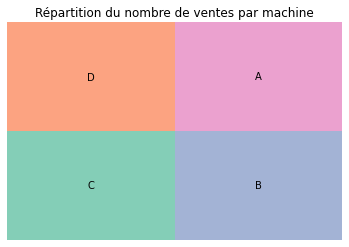

In [ ]:
# Distribution par machine - Squarify :

color = sns.color_palette("Set2")
squarify.plot(sizes = df_boisson['machine'].value_counts(),
              label = labels, alpha = 0.8, color = color)
plt.axis('off')
plt.title("Répartition du nombre de ventes par machine")

plt.show()

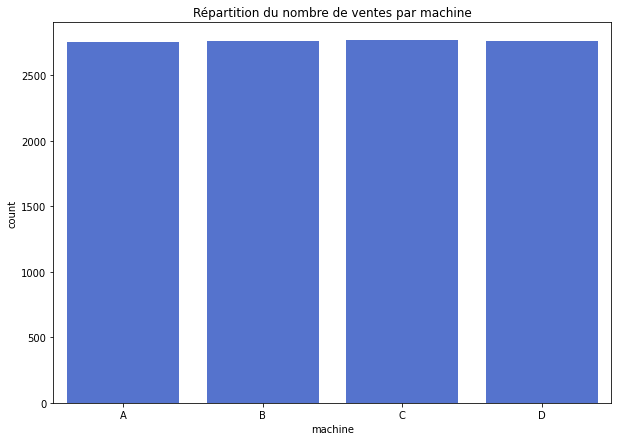

In [ ]:
# Countplot :

plt.figure(figsize = (10, 7))

sns.countplot(data = df_boisson, x = "machine", color = 'royalblue')
plt.title("Répartition du nombre de ventes par machine")
plt.show()

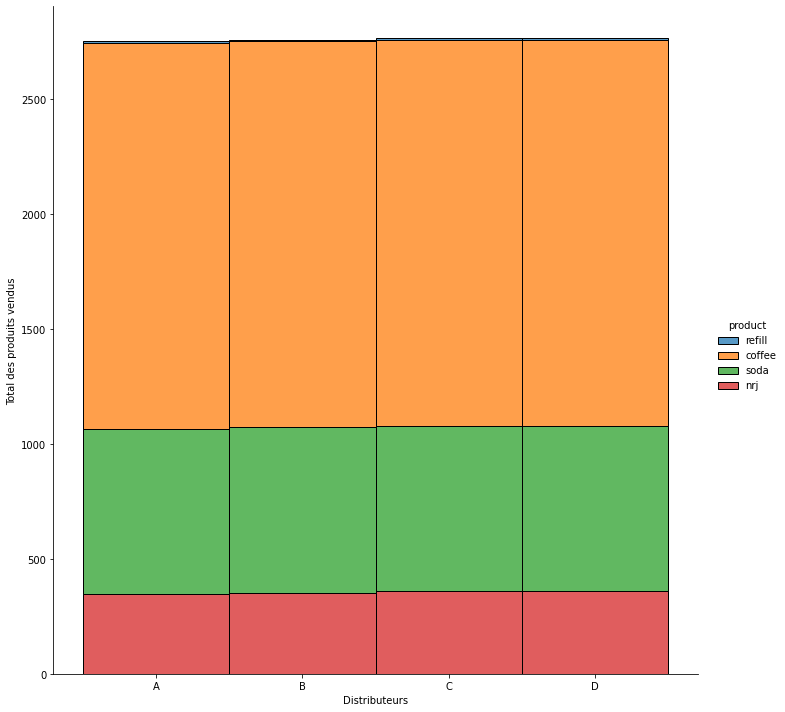

In [ ]:
sns.displot(x = df_boisson["machine"], hue = df_boisson["product"], multiple = "stack", height = 10)
plt.xlabel("Distributeurs")
plt.ylabel("Total des produits vendus")

plt.show()

Les cafés se vendent le mieux, et de loin.

Les quantité vendues sont quasiment les mêmes par machine.

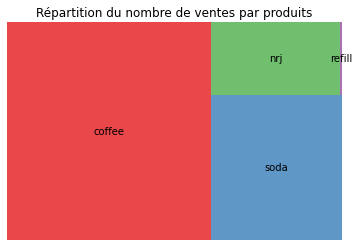

In [ ]:
# Distribution par produits :

labels2 = ['coffee', 'soda', 'nrj', 'refill']

color = sns.color_palette("Set1")
squarify.plot(sizes = df_boisson['product'].value_counts(),
              label = labels2, alpha = 0.8, color = color)
plt.axis('off')
plt.title("Répartition du nombre de ventes par produits")

plt.show()

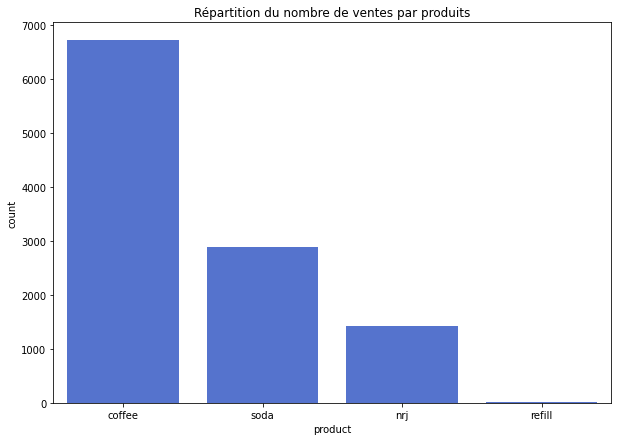

In [ ]:
plt.figure(figsize = (10, 7))

sns.countplot(data = df_boisson, x = "product", color = 'royalblue', order = df_boisson['product'].value_counts().index)
plt.title("Répartition du nombre de ventes par produits")
plt.show()

### Jour de recharge des machines

In [ ]:
refill = df_boisson[df_boisson['product'] == "refill"]
refill

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning,0,0,0,0
6,2019-11-14,refill,B,12:47,Thursday,12,14,11,2019,Morning,0,0,0,0
24,2019-11-14,refill,C,13:51,Thursday,13,14,11,2019,Afternoon,0,0,0,0
43,2019-11-14,refill,D,14:54,Thursday,14,14,11,2019,Afternoon,0,0,0,0
1840,2019-11-21,refill,A,11:55,Thursday,11,21,11,2019,Morning,0,0,0,0
1851,2019-11-21,refill,B,13:33,Thursday,13,21,11,2019,Afternoon,0,0,0,0
1862,2019-11-21,refill,C,14:01,Thursday,14,21,11,2019,Afternoon,0,0,0,0
1883,2019-11-21,refill,D,15:00,Thursday,15,21,11,2019,Afternoon,0,0,0,0
3678,2019-11-28,refill,A,11:54,Thursday,11,28,11,2019,Morning,0,0,0,0
3686,2019-11-28,refill,B,12:54,Thursday,12,28,11,2019,Morning,0,0,0,0


In [ ]:
refill_A = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "A")]
refill_B = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "B")]
refill_C = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "C")]
refill_D = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "D")]

In [ ]:
# Affichage :

refill_A

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning,0,0,0,0
1840,2019-11-21,refill,A,11:55,Thursday,11,21,11,2019,Morning,0,0,0,0
3678,2019-11-28,refill,A,11:54,Thursday,11,28,11,2019,Morning,0,0,0,0
5515,2019-12-05,refill,A,12:34,Thursday,12,5,12,2019,Morning,0,0,0,0
7360,2019-12-12,refill,A,12:21,Thursday,12,12,12,2019,Morning,0,0,0,0
9200,2019-12-19,refill,A,11:49,Thursday,11,19,12,2019,Morning,0,0,0,0


In [ ]:
refill_B

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
6,2019-11-14,refill,B,12:47,Thursday,12,14,11,2019,Morning,0,0,0,0
1851,2019-11-21,refill,B,13:33,Thursday,13,21,11,2019,Afternoon,0,0,0,0
3686,2019-11-28,refill,B,12:54,Thursday,12,28,11,2019,Morning,0,0,0,0
5520,2019-12-05,refill,B,12:54,Thursday,12,5,12,2019,Morning,0,0,0,0
7366,2019-12-12,refill,B,12:55,Thursday,12,12,12,2019,Morning,0,0,0,0
9212,2019-12-19,refill,B,13:06,Thursday,13,19,12,2019,Afternoon,0,0,0,0


In [ ]:
refill_C

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
24,2019-11-14,refill,C,13:51,Thursday,13,14,11,2019,Afternoon,0,0,0,0
1862,2019-11-21,refill,C,14:01,Thursday,14,21,11,2019,Afternoon,0,0,0,0
3700,2019-11-28,refill,C,13:50,Thursday,13,28,11,2019,Afternoon,0,0,0,0
5537,2019-12-05,refill,C,14:01,Thursday,14,5,12,2019,Afternoon,0,0,0,0
7387,2019-12-12,refill,C,14:17,Thursday,14,12,12,2019,Afternoon,0,0,0,0
9231,2019-12-19,refill,C,14:07,Thursday,14,19,12,2019,Afternoon,0,0,0,0


In [ ]:
refill_D

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
43,2019-11-14,refill,D,14:54,Thursday,14,14,11,2019,Afternoon,0,0,0,0
1883,2019-11-21,refill,D,15:00,Thursday,15,21,11,2019,Afternoon,0,0,0,0
3733,2019-11-28,refill,D,15:00,Thursday,15,28,11,2019,Afternoon,0,0,0,0
5579,2019-12-05,refill,D,15:21,Thursday,15,5,12,2019,Afternoon,0,0,0,0
7415,2019-12-12,refill,D,15:14,Thursday,15,12,12,2019,Afternoon,0,0,0,0
9253,2019-12-19,refill,D,14:56,Thursday,14,19,12,2019,Afternoon,0,0,0,0


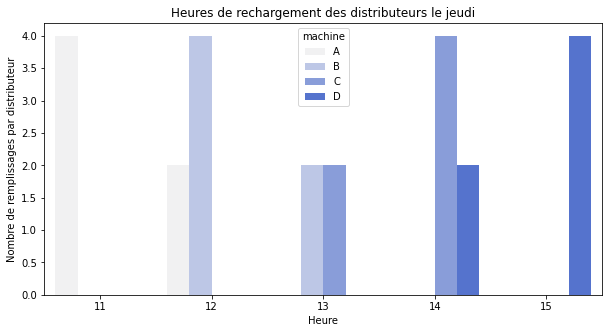

In [ ]:
plt.subplots(figsize = (10, 5))

sns.countplot(data = refill, x = "h", hue = "machine", color = 'royalblue')
plt.ylabel("Nombre de remplissages par distributeur")
plt.xlabel("Heure")
plt.title("Heures de rechargement des distributeurs le jeudi")

plt.show()

Les machines sont rechargées tous les jeudis midi ou début d'après-midi, dans l'ordre alphabétique si on se fie aux heures de remplissage.

L'employé est passé 6 fois remplir toutes les machines durant la période couverte par le dataframe.

### Répartition en fonction des jours de la semaine

In [ ]:
df_boisson.columns

Index(['date', 'product', 'machine', 'hour', 'day', 'h', 'num_day', 'month',
       'year', 'period', 'count_coffee', 'count_soda', 'count_nrj',
       'count_any'],
      dtype='object')

In [ ]:
no_refill = df_boisson[df_boisson['product'] != 'refill']

In [ ]:
# Quantités de boissons consommées chaque jour :

pivot = pd.pivot_table(no_refill, index = ['day', 'num_day', 'month'], columns = 'product', aggfunc = 'count')
pivot.drop(columns=['date','hour','machine', 'h', 'hour', 'year', 'period', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot.reset_index(inplace = True)
pivot.rename(columns={'count_any': 'number'}, inplace = True)
pivot.sort_values('num_day', inplace = True)
pivot.set_index('day', inplace = True)

In [ ]:
pivot

num_day month number             
product                 coffee   nrj   soda
day                                        
Sunday          1    12  114.0  18.0   67.0
Monday          2    12  318.0  12.0   97.0
Tuesday         3    12  166.0  11.0    NaN
Wednesday       4    12    NaN  12.0    NaN
Thursday        5    12   71.0  26.0   77.0
Friday          6    12  348.0  84.0  158.0
Saturday        7    12  123.0  71.0   66.0
Sunday          8    12  118.0  17.0   78.0
Monday          9    12  325.0  17.0  100.0
Tuesday        10    12  135.0  12.0    1.0
Wednesday      11    12    NaN  12.0    NaN
Thursday       12    12   63.0  23.0   84.0
Friday         13    12  324.0  70.0  176.0
Thursday       14    11   69.0  22.0   66.0
Saturday       14    12  122.0  73.0   82.0
Sunday         15    12  104.0  24.0   76.0
Friday         15    11  343.0  84.0  149.0
Saturday       16    11  114.0  67.0   74.0
Monday         16    12  319.0  18.0   62.0
Sunday         17    11  131.0  16.0   79.0
Tuesday        17    12  188.0  16.0    NaN
Wednesday      18    12    NaN  15.0    NaN
Monday         18    11  337.0  16.0  105.0
Tuesday        19    11  123.0  16.0    7.0
Thursday       19    12   70.0  29.0   80.0
Wednesday      20    11    3.0  15.0    NaN
Friday         20    12  318.0  72.0  147.0
Thursday       21    11   61.0  23.0   80.0
Saturday       21    12  105.0  83.0   73.0
Sunday         22    12  111.0  15.0   77.0
Friday         22    11  341.0  61.0  159.0
Saturday       23    11  126.0  79.0   67.0
Monday         23    12  349.0  14.0  100.0
Tuesday        24    12  167.0  16.0    3.0
Sunday         24    11  120.0  21.0   88.0
Wednesday      25    12    NaN   9.0    NaN
Monday         25    11  319.0  16.0   75.0
Tuesday        26    11  153.0  17.0   11.0
Wednesday      27    11    NaN  15.0    NaN
Thursday       28    11   77.0  26.0   65.0
Friday         29    11  330.0  77.0  169.0
Saturday       30    11  115.0  78.0   82.0

In [ ]:
pivot2 = pd.pivot_table(no_refill, index = ['day'], columns = 'product', aggfunc = 'count')
pivot2.drop(columns=['date','hour','machine', 'h', 'hour', 'month', 'year', 'period', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot2.reset_index(inplace = True)
pivot2.rename(columns={'count_any': 'number'}, inplace = True)

pivot2.set_index('day', inplace = True)


del pivot2['num_day']

pivot2

number              
product    coffee    nrj   soda
day                            
Friday     2004.0  448.0  958.0
Monday     1967.0   93.0  539.0
Saturday    705.0  451.0  444.0
Sunday      698.0  111.0  465.0
Thursday    411.0  149.0  452.0
Tuesday     932.0   88.0   22.0
Wednesday     3.0   78.0    NaN

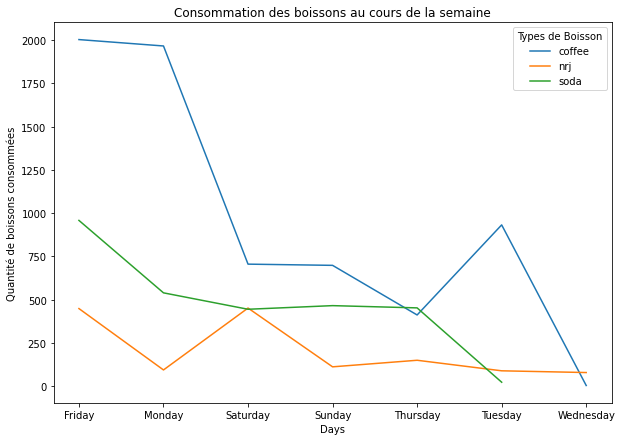

In [ ]:
# Ordre décroissant

plt.figure(figsize = (10, 7))

plt.plot(pivot2)
plt.ylabel('Quantité de boissons consommées')
plt.xlabel('Days')
plt.legend(['coffee', 'nrj', 'soda'], title = 'Types de Boisson')
plt.title('Consommation des boissons au cours de la semaine')

plt.show()

In [ ]:
new_index = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']
pivot2_reindex = pivot2.reindex(new_index)

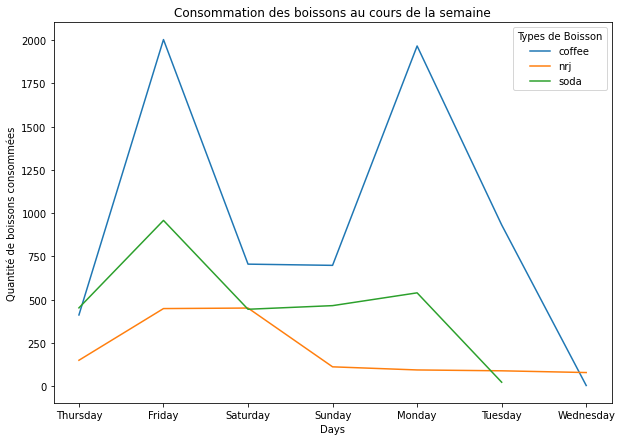

In [ ]:
# Ordre à partir du jeudi : jour de remplissage des distributeurs :

plt.figure(figsize = (10, 7))

plt.plot(pivot2_reindex)
plt.ylabel('Quantité de boissons consommées')
plt.xlabel('Days')
plt.legend(['coffee', 'nrj', 'soda'], title = 'Types de Boisson')
plt.title('Consommation des boissons au cours de la semaine')

plt.show()

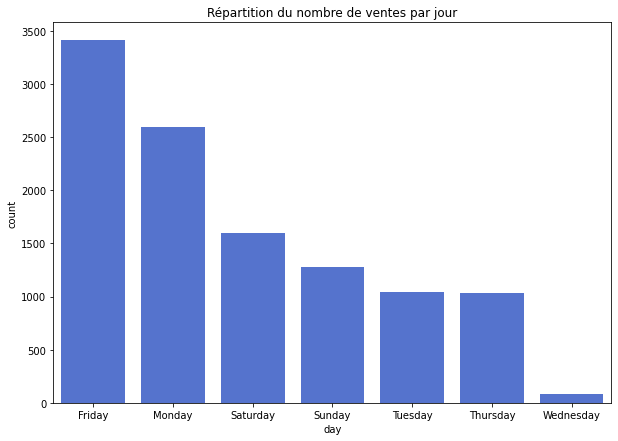

In [ ]:
plt.figure(figsize = (10, 7))

sns.countplot(data = df_boisson, x = "day", color = 'royalblue', order = df_boisson['day'].value_counts().index)
plt.title("Répartition du nombre de ventes par jour")
plt.show()

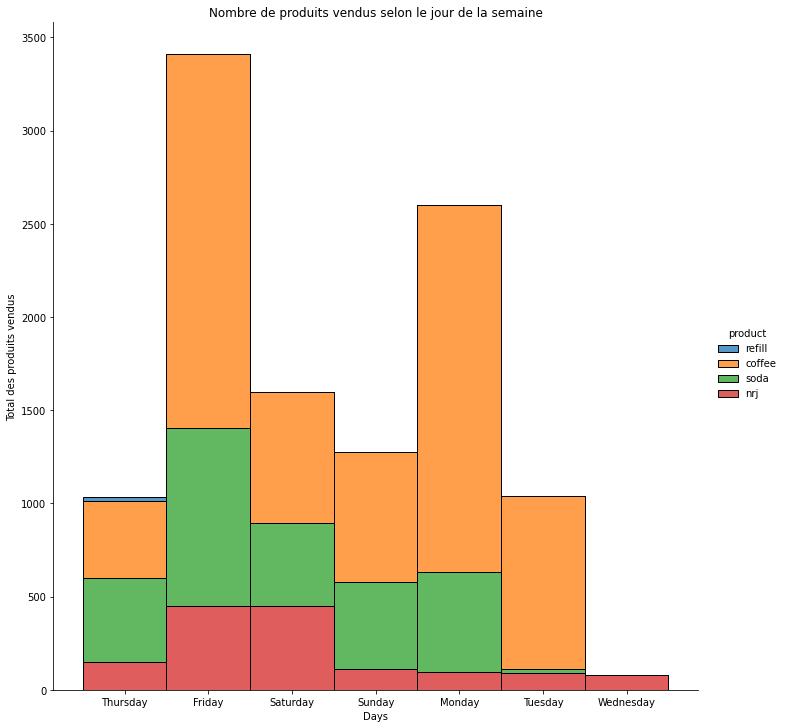

In [ ]:
sns.displot(x=df_boisson["day"], hue = df_boisson["product"], multiple = "stack", height = 10)
plt.title("Nombre de produits vendus selon le jour de la semaine")
plt.ylabel("Total des produits vendus")
plt.xlabel('Days')

plt.show()

Jour avec le moins de ventes : mercredi. C'est même très faible comparé aux autres jours !

Jour avec le plus de ventes : vendredi.

Supposition : vu que le jour de rechargement est le jeudi (voir ci-dessus), mécaniquement, le mercredi est le jour où il y a moins de dispo dans les machines. Et inversement pour le vendredi : les machines viennent d'être rechargées la veille... 

Est-ce la seule raison du faible nombre de ventes le mercredi et du grand nombre de ventes le vendredi ? 

Le samedi et le dimanche font autant de ventes que le jeudi et le mardi.

Pas de ventes de soda et de café le mercredi, probablement car ces produits sont déjà en rupture (et ce sont les deux produits qui se vendent le mieux --> problématique !!).

Beaucoup de ventes aussi le lundi.

Beaucoup de ventes de boissons énergisantes le vendredi et le samedi (donc plutôt en fin de semaine).

Le jeudi, jour de recharge, les ventes sont plus équilibrées.



In [ ]:
# Rappel :

df_boisson['day'].value_counts()

Friday       3410
Monday       2599
Saturday     1600
Sunday       1274
Tuesday      1042
Thursday     1036
Wednesday      81
Name: day, dtype: int64

### Répartition en fonction des heures ('t_hours')

In [ ]:
df_boisson['hour'].value_counts().sum()

11042

In [ ]:
df_boisson['hour'].unique

<bound method Series.unique of 0        11:53
1        12:06
2        12:07
3        12:13
4        12:22
         ...  
11037    20:10
11038    20:16
11039    20:26
11040    21:11
11041    21:43
Name: hour, Length: 11042, dtype: object>

In [ ]:
# Tentative d'histogramme des ventes en fonction des heures :

# plt.figure(figsize = (30, 25))

# sns.histplot(data = df_boisson, x = "hour", color = 'royalblue')
# plt.title("Répartition du nombre de ventes par heures")
# plt.show()

# Illisible !

In [ ]:
# Fonction pour construire des tranches horaires d'une heure :

def tr_horaires(time):
    hour1 = int(time[:2])
    hour2 = int(time[:2]) + 1
    return str(hour1) + "h-" + str(hour2) + "h"

In [ ]:
df_boisson["t_hours"] = df_boisson["hour"].apply(tr_horaires)

In [ ]:
# Création d'un df_refill pour ne garder que les recharges (qui vont disparaître avec le code suivant) :

df_refill = df_boisson[df_boisson['product'] == "refill"]
df_refill

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning,0,0,0,0,11h-12h
6,2019-11-14,refill,B,12:47,Thursday,12,14,11,2019,Morning,0,0,0,0,12h-13h
24,2019-11-14,refill,C,13:51,Thursday,13,14,11,2019,Afternoon,0,0,0,0,13h-14h
43,2019-11-14,refill,D,14:54,Thursday,14,14,11,2019,Afternoon,0,0,0,0,14h-15h
1840,2019-11-21,refill,A,11:55,Thursday,11,21,11,2019,Morning,0,0,0,0,11h-12h
1851,2019-11-21,refill,B,13:33,Thursday,13,21,11,2019,Afternoon,0,0,0,0,13h-14h
1862,2019-11-21,refill,C,14:01,Thursday,14,21,11,2019,Afternoon,0,0,0,0,14h-15h
1883,2019-11-21,refill,D,15:00,Thursday,15,21,11,2019,Afternoon,0,0,0,0,15h-16h
3678,2019-11-28,refill,A,11:54,Thursday,11,28,11,2019,Morning,0,0,0,0,11h-12h
3686,2019-11-28,refill,B,12:54,Thursday,12,28,11,2019,Morning,0,0,0,0,12h-13h


In [ ]:
df_boisson = df_boisson[df_boisson["product"] != "refill"]

In [ ]:
# Liste des tranches horaires :

tranches_horaires = ["0h-1h", "1h-2h", "2h-3h", "3h-4h", "4h-5h", "5h-6h", "6h-7h", "7h-8h", "8h-9h", "9h-10h", 
                     "10h-11h", "11h-12h", "12h-13h", "13h-14h", "14h-15h", "15h-16h", "16h-17h", "17h-18h", "18h-19h",
                     "19h-20h", "20h-21h", "21h-22h", "22h-23h", "23h-24h"]

In [ ]:
df_boisson['t_hours'] = pd.Categorical(df_boisson['t_hours'], categories = tranches_horaires, ordered = True)
df_boisson = df_boisson.sort_values('t_hours')
df_boisson

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
737,2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h
7545,2019-12-13,soda,C,00:52,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7544,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7543,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8374,2019-12-14,soda,B,23:44,Saturday,23,14,12,2019,Night,0,1,0,1,23h-24h
8375,2019-12-14,nrj,C,23:46,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8376,2019-12-14,nrj,B,23:51,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
3675,2019-11-27,nrj,B,23:59,Wednesday,23,27,11,2019,Night,0,0,1,1,23h-24h


In [ ]:
df_boisson['t_hours'].value_counts().sum()

11018

In [ ]:
print(df_boisson['t_hours'].unique())

['0h-1h', '1h-2h', '5h-6h', '6h-7h', '7h-8h', ..., '19h-20h', '20h-21h', '21h-22h', '22h-23h', '23h-24h']
Length: 21
Categories (24, object): ['0h-1h' < '1h-2h' < '2h-3h' < '3h-4h' ... '20h-21h' < '21h-22h' < '22h-23h' <
                          '23h-24h']


In [ ]:
# Vérification des NaN dans 'hour' et 't_hours' :

nan_hour = df_boisson['hour'].isna().sum()
print(f"On a", nan_hour, "valeurs NaN.")

On a 0 valeurs NaN.


In [ ]:
nan_t_hours = df_boisson['t_hours'].isna().sum()
print(f"On a", nan_t_hours, "valeurs NaN.") # pas de NaN dans 'hour' et 't_hours'

On a 0 valeurs NaN.


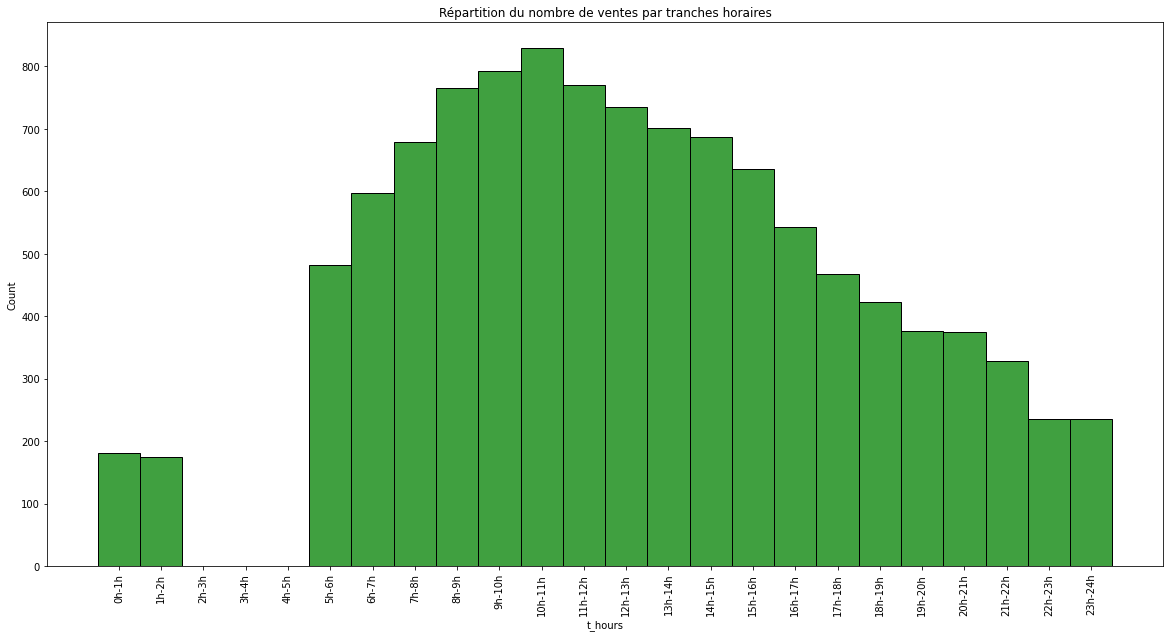

In [ ]:
# Histogramme de répartition du nombre de produits par tranches horaires :

plt.figure(figsize = (20, 10))

sns.histplot(data = df_boisson, x = "t_hours", color = 'green')
plt.title("Répartition du nombre de ventes par tranches horaires")
plt.xticks(rotation = 90)
plt.show()

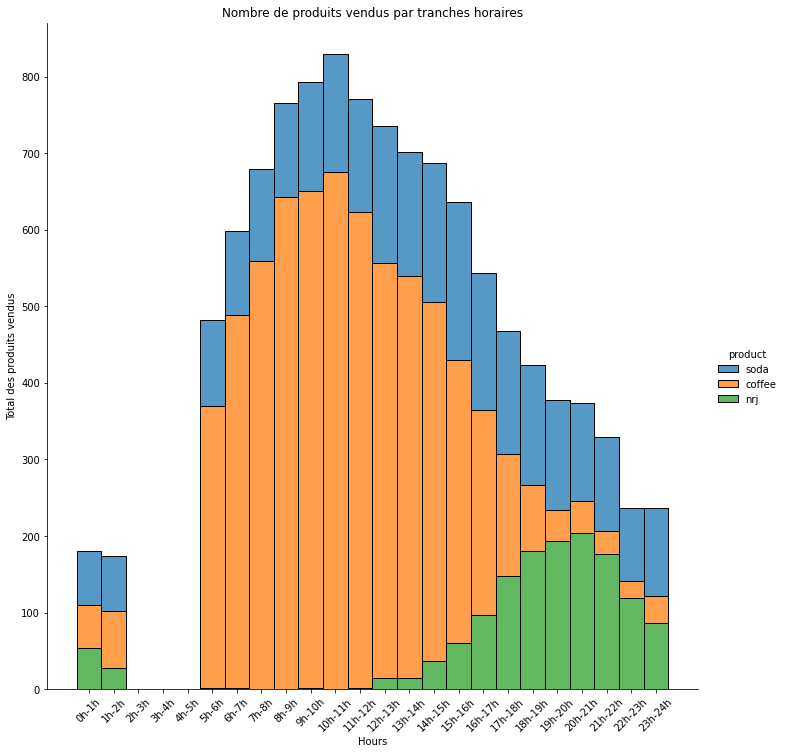

In [ ]:
sns.displot(x = df_boisson["t_hours"], hue = df_boisson["product"], multiple = "stack", height = 10)
plt.title("Nombre de produits vendus par tranches horaires")
plt.ylabel("Total des produits vendus")
plt.xlabel('Hours')
plt.xticks(rotation = 45)

plt.show()

In [ ]:
df_t_hours = df_boisson.groupby(['t_hours', 'product']).count().reset_index()
df_t_hours

,t_hours,product,date,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,0h-1h,coffee,56,56,56,56,56,56,56,56,56,56,56,56,56
1,0h-1h,nrj,54,54,54,54,54,54,54,54,54,54,54,54,54
2,0h-1h,soda,71,71,71,71,71,71,71,71,71,71,71,71,71
3,1h-2h,coffee,75,75,75,75,75,75,75,75,75,75,75,75,75
4,1h-2h,nrj,27,27,27,27,27,27,27,27,27,27,27,27,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,22h-23h,nrj,119,119,119,119,119,119,119,119,119,119,119,119,119
68,22h-23h,soda,95,95,95,95,95,95,95,95,95,95,95,95,95
69,23h-24h,coffee,35,35,35,35,35,35,35,35,35,35,35,35,35
70,23h-24h,nrj,86,86,86,86,86,86,86,86,86,86,86,86,86


In [ ]:
# Version px :

fig = px.bar(df_t_hours, x='t_hours', y = 'count_any', color="product", text="product", title = 'Ventes par heures et par boisson', labels = {'product' : ''})
fig.update_layout(showlegend=False, title_x=0.5)
fig.update_xaxes(tickangle=45)
fig.show()

In [ ]:
df_boisson['t_hours'].value_counts()

10h-11h    829
9h-10h     793
11h-12h    771
8h-9h      766
12h-13h    735
13h-14h    701
14h-15h    687
7h-8h      679
15h-16h    636
6h-7h      598
16h-17h    543
5h-6h      482
17h-18h    468
18h-19h    423
19h-20h    377
20h-21h    374
21h-22h    329
22h-23h    236
23h-24h    236
0h-1h      181
1h-2h      174
4h-5h        0
3h-4h        0
2h-3h        0
Name: t_hours, dtype: int64

Pas de ventes entre 2h et 5h du matin. La gare est fermée à ces horaires.

Le pic de ventes a lieu entre 9 et 13h, donc en matinée.

Le café se vend très bien le matin et le midi, les boissons énergisantes plutôt le soir.

### Répartition en fonction des périodes de la journée ('period')

In [ ]:
no_refill = df_boisson[df_boisson['product'] != 'refill']
no_refill

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
737,2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h
7545,2019-12-13,soda,C,00:52,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7544,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7543,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8374,2019-12-14,soda,B,23:44,Saturday,23,14,12,2019,Night,0,1,0,1,23h-24h
8375,2019-12-14,nrj,C,23:46,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8376,2019-12-14,nrj,B,23:51,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
3675,2019-11-27,nrj,B,23:59,Wednesday,23,27,11,2019,Night,0,0,1,1,23h-24h


In [ ]:
no_refill.columns

Index(['date', 'product', 'machine', 'hour', 'day', 'h', 'num_day', 'month',
       'year', 'period', 'count_coffee', 'count_soda', 'count_nrj',
       'count_any', 't_hours'],
      dtype='object')

In [ ]:
pivot3 = pd.pivot_table(no_refill, index = 'period', columns = 'product', aggfunc = 'count')
pivot3.drop(columns=['date', 'day', 'hour', 'month', 'year', 'h', 'machine','num_day', 't_hours', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot3.rename(columns={'count_any': 'number'}, inplace = True)
pivot3

number           
product   coffee  nrj  soda
period                     
Afternoon   1788  357   890
Evening      198  755   550
Morning     4546   20  1087
Night        188  286   353

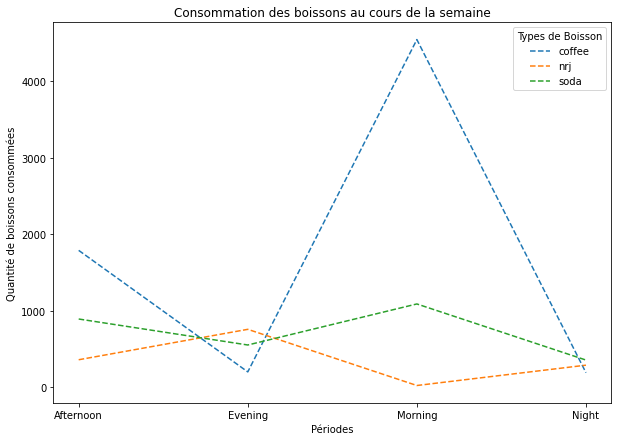

In [ ]:
plt.figure(figsize = (10, 7))

plt.plot(pivot3, linestyle = 'dashed')
plt.legend(['coffee', 'nrj', 'soda'], title = 'Types de Boisson')
plt.ylabel('Quantité de boissons consommées')
plt.xlabel('Périodes')
plt.title('Consommation des boissons au cours de la semaine')
plt.show()

Les boissons énergisantes se vendent plus le soir.

Le café se vend surtout le matin.

Les sodas se vendent surtout l'après-midi.

In [ ]:
# Ventes par périodes et par machines :

pivot4 = pd.pivot_table(no_refill, index = ['period', 'machine'], columns = 'product', aggfunc = 'count')
pivot4.drop(columns=['date', 'day', 'hour', 'month', 'year', 'h','num_day', 't_hours', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot4.rename(columns={'count_any': 'number'}, inplace = True)

pivot4

number          
product           coffee  nrj soda
period    machine                 
Afternoon A          445   91  236
          B          472   86  240
          C          416   87  224
          D          455   93  190
Evening   A           47  173  123
          B           45  197  132
          C           57  206  146
          D           49  179  149
Morning   A         1141    6  285
          B         1122    5  271
          C         1153    3  257
          D         1130    6  274
Night     A           47   76   76
          B           41   65   77
          C           54   64   93
          D           46   81  107

Peu de différences entre les 4 distributeurs, quel que soit le moment de la journée.

### Répartition par semaine sur les 2 mois

In [ ]:
november = df_boisson[df_boisson['month'] == 11]
november

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
737,2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h
738,2019-11-16,nrj,D,00:11,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
739,2019-11-16,nrj,C,00:16,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
741,2019-11-16,nrj,A,00:28,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
992,2019-11-17,soda,B,00:05,Sunday,0,17,11,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,2019-11-28,soda,A,23:23,Thursday,23,28,11,2019,Night,0,1,0,1,23h-24h
3841,2019-11-28,coffee,B,23:17,Thursday,23,28,11,2019,Night,1,0,0,1,23h-24h
3840,2019-11-28,soda,C,23:03,Thursday,23,28,11,2019,Night,0,1,0,1,23h-24h
987,2019-11-16,nrj,D,23:36,Saturday,23,16,11,2019,Night,0,0,1,1,23h-24h


In [ ]:
december = df_boisson[df_boisson['month'] == 12]
december

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
7545,2019-12-13,soda,C,00:52,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7544,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7543,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7542,2019-12-13,soda,B,00:35,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,2019-12-14,nrj,A,23:39,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8374,2019-12-14,soda,B,23:44,Saturday,23,14,12,2019,Night,0,1,0,1,23h-24h
8375,2019-12-14,nrj,C,23:46,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8376,2019-12-14,nrj,B,23:51,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h


Plus de ventes en décembre qu'en novembre. Mais c'est normal : le dataframe contient plus de jours en décembre (24) qu'en novembre (17).

In [ ]:
# Ventes de novembre par machine et par période

pivot5 = pd.pivot_table(november, index = ['period', 'machine'], columns = 'product', aggfunc = 'count')
pivot5.drop(columns=['date', 'day', 'hour', 'month', 'year', 'h','num_day', 't_hours', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot5.rename(columns={'count_any': 'number'}, inplace = True)

pivot5

number          
product           coffee  nrj soda
period    machine                 
Afternoon A          190   38  103
          B          206   42  107
          C          185   43   99
          D          192   51   97
Evening   A           16   73   52
          B           13   75   56
          C           19  111   55
          D           17   87   66
Morning   A          470    3  121
          B          458    4  119
          C          469    1  128
          D          454    3  125
Night     A           11   39   35
          B           20   25   28
          C           17   22   47
          D           25   32   38

In [ ]:
# Ventes de décembre par machine et par période

pivot5 = pd.pivot_table(december, index = ['period', 'machine'], columns = 'product', aggfunc = 'count')
pivot5.drop(columns=['date', 'day', 'hour', 'month', 'year', 'h','num_day', 't_hours', 'count_coffee', 'count_nrj', 'count_soda'], inplace = True)
pivot5.rename(columns={'count_any': 'number'}, inplace = True)

pivot5

number          
product           coffee  nrj soda
period    machine                 
Afternoon A          255   53  133
          B          266   44  133
          C          231   44  125
          D          263   42   93
Evening   A           31  100   71
          B           32  122   76
          C           38   95   91
          D           32   92   83
Morning   A          671    3  164
          B          664    1  152
          C          684    2  129
          D          676    3  149
Night     A           36   37   41
          B           21   40   49
          C           37   42   46
          D           21   49   69

Peu de différences par machine.

#### Semaine du 14 au 20 novembre

In [ ]:
nov_w1 = november[november['num_day'] < 21]
nov_w1

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
737,2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h
738,2019-11-16,nrj,D,00:11,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
739,2019-11-16,nrj,C,00:16,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
741,2019-11-16,nrj,A,00:28,Saturday,0,16,11,2019,Night,0,0,1,1,0h-1h
992,2019-11-17,soda,B,00:05,Sunday,0,17,11,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2019-11-19,coffee,B,23:22,Tuesday,23,19,11,2019,Night,1,0,0,1,23h-24h
1818,2019-11-19,nrj,D,23:07,Tuesday,23,19,11,2019,Night,0,0,1,1,23h-24h
1675,2019-11-18,soda,B,23:53,Monday,23,18,11,2019,Night,0,1,0,1,23h-24h
159,2019-11-14,soda,A,23:07,Thursday,23,14,11,2019,Night,0,1,0,1,23h-24h


In [ ]:
group_w1 = nov_w1.groupby(by=['num_day', 'day', 'product']).count()
group_w1.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w1

machine
num_day day       product         
14      Thursday  coffee        69
                  nrj           22
                  soda          66
15      Friday    coffee       343
                  nrj           84
                  soda         149
16      Saturday  coffee       114
                  nrj           67
                  soda          74
17      Sunday    coffee       131
                  nrj           16
                  soda          79
18      Monday    coffee       337
                  nrj           16
                  soda         105
19      Tuesday   coffee       123
                  nrj           16
                  soda           7
20      Wednesday coffee         3
                  nrj           15

In [ ]:
nov_w1['product'].value_counts()

coffee    1120
soda       480
nrj        236
Name: product, dtype: int64

In [ ]:
pivot6 = pd.pivot_table(nov_w1, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot6.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot6.rename(columns={'count_any': 'number'}, inplace = True)
pivot6

number             
product           coffee   nrj   soda
num_day day                          
14      Thursday    69.0  22.0   66.0
15      Friday     343.0  84.0  149.0
16      Saturday   114.0  67.0   74.0
17      Sunday     131.0  16.0   79.0
18      Monday     337.0  16.0  105.0
19      Tuesday    123.0  16.0    7.0
20      Wednesday    3.0  15.0    NaN

In [ ]:
coffee_w1 = print('Nombre de cafés vendus la semaine du 14 au 20/11 :', 69 + 343 + 114 + 131 + 337 + 123 + 3, 'sur un total de 1120 disponibles.')
soda_w1 = print('Nombre de soda vendus la semaine du 14 au 20/11 :', 66 + 149 + 74 + 79 + 105 + 7, 'sur un total de 480 disponibles.')
nrj_w1 = print('Nombre de nrj drink vendus la semaine du 14 au 20/11 :', 22 + 84 + 67 + 16 + 16 + 16 + 15, 'sur un total de 240 disponibles.')

Nombre de cafés vendus la semaine du 14 au 20/11 : 1120 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 14 au 20/11 : 480 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 14 au 20/11 : 236 sur un total de 240 disponibles.


On a la preuve ici que pour cette semaine, tous les cafés et sodas sont vendus, ce qui explique la raison pour laquelle il y a moins de ventes le mercredi : les distributeurs pour ces deux boissons sont vides !

Ok pour les nrj drink puisqu'il en reste 4.

#### Semaine du 21 au 27 novembre

In [ ]:
nov_w2 = november[(november['num_day'] >= 21) & (november['num_day'] < 28)]
nov_w2

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
2009,2019-11-22,soda,D,00:12,Friday,0,22,11,2019,Night,0,1,0,1,0h-1h
2570,2019-11-23,coffee,B,00:11,Saturday,0,23,11,2019,Night,1,0,0,1,0h-1h
2571,2019-11-23,soda,D,00:28,Saturday,0,23,11,2019,Night,0,1,0,1,0h-1h
2572,2019-11-23,coffee,D,00:35,Saturday,0,23,11,2019,Night,1,0,0,1,0h-1h
2573,2019-11-23,nrj,A,00:47,Saturday,0,23,11,2019,Night,0,0,1,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2834,2019-11-23,nrj,C,23:42,Saturday,23,23,11,2019,Night,0,0,1,1,23h-24h
2833,2019-11-23,soda,D,23:41,Saturday,23,23,11,2019,Night,0,1,0,1,23h-24h
3660,2019-11-26,coffee,D,23:56,Tuesday,23,26,11,2019,Night,1,0,0,1,23h-24h
3674,2019-11-27,nrj,B,23:40,Wednesday,23,27,11,2019,Night,0,0,1,1,23h-24h


In [ ]:
group_w2 = nov_w2.groupby(by=['num_day', 'day', 'product']).count()
group_w2.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w2

machine
num_day day       product         
21      Thursday  coffee        61
                  nrj           23
                  soda          80
22      Friday    coffee       341
                  nrj           61
                  soda         159
23      Saturday  coffee       126
                  nrj           79
                  soda          67
24      Sunday    coffee       120
                  nrj           21
                  soda          88
25      Monday    coffee       319
                  nrj           16
                  soda          75
26      Tuesday   coffee       153
                  nrj           17
                  soda          11
27      Wednesday nrj           15

In [ ]:
nov_w2['product'].value_counts()

coffee    1120
soda       480
nrj        232
Name: product, dtype: int64

In [ ]:
pivot7 = pd.pivot_table(nov_w2, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot7.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot7.rename(columns={'count_any': 'number'}, inplace = True)
pivot7

number             
product           coffee   nrj   soda
num_day day                          
21      Thursday    61.0  23.0   80.0
22      Friday     341.0  61.0  159.0
23      Saturday   126.0  79.0   67.0
24      Sunday     120.0  21.0   88.0
25      Monday     319.0  16.0   75.0
26      Tuesday    153.0  17.0   11.0
27      Wednesday    NaN  15.0    NaN

In [ ]:
coffee_w2 = print('Nombre de cafés vendus la semaine du 21 au 27/11 :', 61 + 341 + 126 + 120 + 319 + 153, 'sur un total de 1120 disponibles.')
soda_w2 = print('Nombre de soda vendus la semaine du 21 au 27/11 :', 80 + 159 + 67 + 88 + 75 + 11, 'sur un total de 480 disponibles.')
nrj_w2 = print('Nombre de nrj drink vendus la semaine du 21 au 27/11 :', 23 + 61 + 79 + 21 + 16 + 17 + 15, 'sur un total de 232 disponibles.')

Nombre de cafés vendus la semaine du 21 au 27/11 : 1120 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 21 au 27/11 : 480 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 21 au 27/11 : 232 sur un total de 232 disponibles.


Cette semaine là, tout a été vendu !

#### 28 novembre au 30 novembre

In [ ]:
nov_w3 = november[(november['num_day'] >= 28) & (november['num_day'] <= 30)]
nov_w3

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
4424,2019-11-30,nrj,D,00:40,Saturday,0,30,11,2019,Night,0,0,1,1,0h-1h
3856,2019-11-29,coffee,B,00:53,Friday,0,29,11,2019,Night,1,0,0,1,0h-1h
3855,2019-11-29,coffee,A,00:40,Friday,0,29,11,2019,Night,1,0,0,1,0h-1h
3676,2019-11-28,nrj,A,00:01,Thursday,0,28,11,2019,Night,0,0,1,1,0h-1h
3677,2019-11-28,nrj,B,00:03,Thursday,0,28,11,2019,Night,0,0,1,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3844,2019-11-28,nrj,D,23:28,Thursday,23,28,11,2019,Night,0,0,1,1,23h-24h
3843,2019-11-28,soda,D,23:24,Thursday,23,28,11,2019,Night,0,1,0,1,23h-24h
3842,2019-11-28,soda,A,23:23,Thursday,23,28,11,2019,Night,0,1,0,1,23h-24h
3841,2019-11-28,coffee,B,23:17,Thursday,23,28,11,2019,Night,1,0,0,1,23h-24h


In [ ]:
group_w3 = nov_w3.groupby(by=['num_day', 'day', 'product']).count()
group_w3.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w3

machine
num_day day      product         
28      Thursday coffee        77
                 nrj           26
                 soda          65
29      Friday   coffee       330
                 nrj           77
                 soda         169
30      Saturday coffee       115
                 nrj           78
                 soda          82

In [ ]:
nov_w3['product'].value_counts()

coffee    522
soda      316
nrj       181
Name: product, dtype: int64

In [ ]:
pivot8 = pd.pivot_table(nov_w3, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot8.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot8.rename(columns={'count_any': 'number'}, inplace = True)
pivot8

number         
product          coffee nrj soda
num_day day                     
28      Thursday     77  26   65
29      Friday      330  77  169
30      Saturday    115  78   82

In [ ]:
coffee_w3 = print('Nombre de cafés vendus la semaine du 28 au 30/11 :', 77 + 330 + 115, 'sur un total de 1120 disponibles.')
soda_w3 = print('Nombre de soda vendus la semaine du 28 au 30/11 :',  + 169 + 65 + 82, 'sur un total de 480 disponibles.')
nrj_w3 = print('Nombre de nrj drink vendus la semaine du 28 au 30/11 :', 26 + 77 + 78, 'sur un total de 240 disponibles.')

Nombre de cafés vendus la semaine du 28 au 30/11 : 522 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 28 au 30/11 : 316 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 28 au 30/11 : 181 sur un total de 240 disponibles.


#### 1er au 4 décembre

In [ ]:
nov_w4 = december[(december['num_day'] >= 1) & (december['num_day'] < 5)]
nov_w4

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
4700,2019-12-01,nrj,A,00:12,Sunday,0,1,12,2019,Night,0,0,1,1,0h-1h
4701,2019-12-01,soda,B,00:23,Sunday,0,1,12,2019,Night,0,1,0,1,0h-1h
4702,2019-12-01,coffee,C,00:38,Sunday,0,1,12,2019,Night,1,0,0,1,0h-1h
4699,2019-12-01,nrj,A,00:00,Sunday,0,1,12,2019,Night,0,0,1,1,0h-1h
4898,2019-12-02,coffee,A,00:11,Monday,0,2,12,2019,Night,1,0,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5323,2019-12-02,soda,D,23:39,Monday,23,2,12,2019,Night,0,1,0,1,23h-24h
5322,2019-12-02,soda,B,23:36,Monday,23,2,12,2019,Night,0,1,0,1,23h-24h
5321,2019-12-02,nrj,A,23:26,Monday,23,2,12,2019,Night,0,0,1,1,23h-24h
5319,2019-12-02,soda,A,23:10,Monday,23,2,12,2019,Night,0,1,0,1,23h-24h


In [ ]:
group_w4 = nov_w4.groupby(by=['num_day', 'day', 'product']).count()
group_w4.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w4

machine
num_day day       product         
1       Sunday    coffee       114
                  nrj           18
                  soda          67
2       Monday    coffee       318
                  nrj           12
                  soda          97
3       Tuesday   coffee       166
                  nrj           11
4       Wednesday nrj           12

In [ ]:
nov_w4['product'].value_counts()

coffee    598
soda      164
nrj        53
Name: product, dtype: int64

In [ ]:
pivot8 = pd.pivot_table(nov_w4, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot8.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot8.rename(columns={'count_any': 'number'}, inplace = True)
pivot8

number            
product           coffee   nrj  soda
num_day day                         
1       Sunday     114.0  18.0  67.0
2       Monday     318.0  12.0  97.0
3       Tuesday    166.0  11.0   NaN
4       Wednesday    NaN  12.0   NaN

In [ ]:
coffee_w4 = print('Nombre de cafés vendus la semaine du 1 au 4/12 :', 114 + 318 + 166, 'sur un total de 1120 disponibles.')
soda_w4 = print('Nombre de soda vendus la semaine du 1 au 4/12 :', 67 + 97, 'sur un total de 480 disponibles.')
nrj_w4 = print('Nombre de nrj drink vendus la semaine du 1 au 4/12 :', 18 + 12 +11 + 12, 'sur un total de 232 disponibles.')

Nombre de cafés vendus la semaine du 1 au 4/12 : 598 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 1 au 4/12 : 164 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 1 au 4/12 : 53 sur un total de 232 disponibles.


Concernant le soda, on observe une rupture de stock dès le mardi !

#### Semaine du 5 au 11 décembre

In [ ]:
nov_w5 = december[(december['num_day'] >= 5) & (december['num_day'] < 12)]
nov_w5

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
6758,2019-12-09,coffee,C,00:19,Monday,0,9,12,2019,Night,1,0,0,1,0h-1h
6757,2019-12-09,nrj,A,00:17,Monday,0,9,12,2019,Night,0,0,1,1,0h-1h
6756,2019-12-09,soda,D,00:11,Monday,0,9,12,2019,Night,0,1,0,1,0h-1h
6755,2019-12-09,soda,B,00:11,Monday,0,9,12,2019,Night,0,1,0,1,0h-1h
5692,2019-12-06,soda,C,00:09,Friday,0,6,12,2019,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7343,2019-12-10,nrj,A,23:08,Tuesday,23,10,12,2019,Night,0,0,1,1,23h-24h
7344,2019-12-10,nrj,D,23:45,Tuesday,23,10,12,2019,Night,0,0,1,1,23h-24h
7356,2019-12-11,nrj,B,23:35,Wednesday,23,11,12,2019,Night,0,0,1,1,23h-24h
6281,2019-12-06,nrj,A,23:59,Friday,23,6,12,2019,Night,0,0,1,1,23h-24h


In [ ]:
group_w5 = nov_w5.groupby(by=['num_day', 'day', 'product']).count()
group_w5.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w5

machine
num_day day       product         
5       Thursday  coffee        71
                  nrj           26
                  soda          77
6       Friday    coffee       348
                  nrj           84
                  soda         158
7       Saturday  coffee       123
                  nrj           71
                  soda          66
8       Sunday    coffee       118
                  nrj           17
                  soda          78
9       Monday    coffee       325
                  nrj           17
                  soda         100
10      Tuesday   coffee       135
                  nrj           12
                  soda           1
11      Wednesday nrj           12

In [ ]:
nov_w5['product'].value_counts()

coffee    1120
soda       480
nrj        239
Name: product, dtype: int64

In [ ]:
pivot9 = pd.pivot_table(nov_w5, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot9.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot9.rename(columns={'count_any': 'number'}, inplace = True)
pivot9

number             
product           coffee   nrj   soda
num_day day                          
5       Thursday    71.0  26.0   77.0
6       Friday     348.0  84.0  158.0
7       Saturday   123.0  71.0   66.0
8       Sunday     118.0  17.0   78.0
9       Monday     325.0  17.0  100.0
10      Tuesday    135.0  12.0    1.0
11      Wednesday    NaN  12.0    NaN

In [ ]:
coffee_w5 = print('Nombre de cafés vendus la semaine du 5 au 11/12 :', 71 + 348 + 123 + 118 + 325 + 135, 'sur un total de 1120 disponibles.')
soda_w5 = print('Nombre de soda vendus la semaine du 5 au 11/12 :', 77 + 158 + 66 + 78 + 100 + 1, 'sur un total de 480 disponibles.')
nrj_w5 = print('Nombre de nrj drink vendus la semaine du 5 au 11/12 :', 26 + 84 + 71 + 17 + 17 + 12 + 12, 'sur un total de 240 disponibles.')

Nombre de cafés vendus la semaine du 5 au 11/12 : 1120 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 5 au 11/12 : 480 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 5 au 11/12 : 239 sur un total de 240 disponibles.


Cette semaine là, tout a été vendu sauf 1 nrj drink !

#### Semaine du 12 au 18 décembre

In [ ]:
nov_w6 = december[(december['num_day'] >= 12) & (december['num_day'] < 19)]
nov_w6

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
7545,2019-12-13,soda,C,00:52,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7544,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7543,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7542,2019-12-13,soda,B,00:35,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7541,2019-12-13,coffee,B,00:34,Friday,0,13,12,2019,Night,1,0,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,2019-12-14,nrj,A,23:29,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8373,2019-12-14,nrj,A,23:39,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h
8374,2019-12-14,soda,B,23:44,Saturday,23,14,12,2019,Night,0,1,0,1,23h-24h
8375,2019-12-14,nrj,C,23:46,Saturday,23,14,12,2019,Night,0,0,1,1,23h-24h


In [ ]:
group_w6 = nov_w6.groupby(by=['num_day', 'day', 'product']).count()
group_w6.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w6

machine
num_day day       product         
12      Thursday  coffee        63
                  nrj           23
                  soda          84
13      Friday    coffee       324
                  nrj           70
                  soda         176
14      Saturday  coffee       122
                  nrj           73
                  soda          82
15      Sunday    coffee       104
                  nrj           24
                  soda          76
16      Monday    coffee       319
                  nrj           18
                  soda          62
17      Tuesday   coffee       188
                  nrj           16
18      Wednesday nrj           15

In [ ]:
nov_w6['product'].value_counts()

coffee    1120
soda       480
nrj        239
Name: product, dtype: int64

In [ ]:
pivot10 = pd.pivot_table(nov_w6, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot10.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot10.rename(columns={'count_any': 'number'}, inplace = True)
pivot10

number             
product           coffee   nrj   soda
num_day day                          
12      Thursday    63.0  23.0   84.0
13      Friday     324.0  70.0  176.0
14      Saturday   122.0  73.0   82.0
15      Sunday     104.0  24.0   76.0
16      Monday     319.0  18.0   62.0
17      Tuesday    188.0  16.0    NaN
18      Wednesday    NaN  15.0    NaN

In [ ]:
coffee_w6 = print('Nombre de cafés vendus la semaine du 12 au 18/12 :', 63 + 324 + 122 + 104 + 319 + 188, 'sur un total de 1120 disponibles.')
soda_w6 = print('Nombre de soda vendus la semaine du 12 au 18/12 :', 84 + 176 + 82 + 76 + 62, 'sur un total de 480 disponibles.')
nrj_w6 = print('Nombre de nrj drink vendus la semaine du 12 au 18/12 :', 23 + 70 + 73 + 24 + 18 + 16 + 15, 'sur un total de 240 disponibles.')

Nombre de cafés vendus la semaine du 12 au 18/12 : 1120 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 12 au 18/12 : 480 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 12 au 18/12 : 239 sur un total de 240 disponibles.


Cette semaine là, tout a été vendu sauf 1 nrj drink et les sodas étaient en rupture dès le mardi.

#### Semaine du 19 au 25 décembre

In [ ]:
nov_w7 = december[(december['num_day'] >= 19) & (december['num_day'] < 26)]
nov_w7

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
10384,2019-12-23,coffee,D,00:01,Monday,0,23,12,2019,Night,1,0,0,1,0h-1h
10385,2019-12-23,coffee,D,00:17,Monday,0,23,12,2019,Night,1,0,0,1,0h-1h
10386,2019-12-23,soda,C,00:18,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
10388,2019-12-23,coffee,A,00:30,Monday,0,23,12,2019,Night,1,0,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10840,2019-12-23,nrj,D,23:26,Monday,23,23,12,2019,Night,0,0,1,1,23h-24h
10839,2019-12-23,soda,C,23:22,Monday,23,23,12,2019,Night,0,1,0,1,23h-24h
10838,2019-12-23,soda,A,23:11,Monday,23,23,12,2019,Night,0,1,0,1,23h-24h
10837,2019-12-23,soda,A,23:10,Monday,23,23,12,2019,Night,0,1,0,1,23h-24h


In [ ]:
group_w7 = nov_w7.groupby(by=['num_day', 'day', 'product']).count()
group_w7.drop(columns=['date', 'hour', 'month', 'year', 'h', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'count_any', 'period'], inplace = True)

group_w7

machine
num_day day       product         
19      Thursday  coffee        70
                  nrj           29
                  soda          80
20      Friday    coffee       318
                  nrj           72
                  soda         147
21      Saturday  coffee       105
                  nrj           83
                  soda          73
22      Sunday    coffee       111
                  nrj           15
                  soda          77
23      Monday    coffee       349
                  nrj           14
                  soda         100
24      Tuesday   coffee       167
                  nrj           16
                  soda           3
25      Wednesday nrj            9

In [ ]:
nov_w7['product'].value_counts()

coffee    1120
soda       480
nrj        238
Name: product, dtype: int64

In [ ]:
pivot11 = pd.pivot_table(nov_w7, index = ['num_day', 'day'], columns = 'product', aggfunc = 'count')
pivot11.drop(columns=['date', 'hour', 'month', 'year', 'h', 'machine', 't_hours', 'count_coffee', 'count_nrj', 'count_soda', 'period'], inplace = True)
pivot11.rename(columns={'count_any': 'number'}, inplace = True)
pivot11

number             
product           coffee   nrj   soda
num_day day                          
19      Thursday    70.0  29.0   80.0
20      Friday     318.0  72.0  147.0
21      Saturday   105.0  83.0   73.0
22      Sunday     111.0  15.0   77.0
23      Monday     349.0  14.0  100.0
24      Tuesday    167.0  16.0    3.0
25      Wednesday    NaN   9.0    NaN

In [ ]:
coffee_w7 = print('Nombre de cafés vendus la semaine du 19 au 25/12 :', 70 + 318 + 105 + 111 + 349 + 167, 'sur un total de 1120 disponibles.')
soda_w7 = print('Nombre de soda vendus la semaine du 18 au 25/12 :', 80 + 147 + 73 + 77 + 100 + 3, 'sur un total de 480 disponibles.')
nrj_w7 = print('Nombre de nrj drink vendus la semaine du 19 au 25/12 :', 29 + 72 + 83 + 15 + 14 + 16 + 9, 'sur un total de 238 disponibles.')

Nombre de cafés vendus la semaine du 19 au 25/12 : 1120 sur un total de 1120 disponibles.
Nombre de soda vendus la semaine du 18 au 25/12 : 480 sur un total de 480 disponibles.
Nombre de nrj drink vendus la semaine du 19 au 25/12 : 238 sur un total de 238 disponibles.


Cette semaine là, tout a été vendu sauf 2 nrj drink.

Conclusion : il faudrait un passage supplémentaire de l'employé le lundi ou le mardi pour remplir les cafés et sodas, mais pas forcément pour les nrj drink, qui sont bien répartis avec la recharge du jeudi.

### Calplot et Heatmap : total des ventes en fonction par date en 2019

#### + d'infos sur les dates

In [ ]:
df_boisson.head()

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
737,2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h
7545,2019-12-13,soda,C,00:52,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7544,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h
7543,2019-12-13,soda,D,00:48,Friday,0,13,12,2019,Night,0,1,0,1,0h-1h


In [ ]:
df_boisson['date'].value_counts()

2019-12-06    590
2019-11-29    576
2019-11-15    576
2019-12-13    570
2019-11-22    561
2019-12-20    537
2019-12-23    463
2019-11-18    458
2019-12-09    442
2019-12-02    427
2019-11-25    410
2019-12-16    399
2019-12-14    277
2019-11-30    275
2019-11-23    272
2019-12-21    261
2019-12-07    260
2019-11-16    255
2019-11-24    229
2019-11-17    226
2019-12-08    213
2019-12-17    204
2019-12-15    204
2019-12-22    203
2019-12-01    199
2019-12-24    186
2019-11-26    181
2019-12-19    179
2019-12-03    177
2019-12-05    174
2019-12-12    170
2019-11-28    168
2019-11-21    164
2019-11-14    157
2019-12-10    148
2019-11-19    146
2019-11-20     18
2019-11-27     15
2019-12-18     15
2019-12-04     12
2019-12-11     12
2019-12-25      9
Name: date, dtype: int64

In [ ]:
# Date min :

df_boisson['date'].min()

Timestamp('2019-11-14 00:00:00')

In [ ]:
df_boisson[df_boisson['date'] == '2019-11-14'] 

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
12,2019-11-14,coffee,A,12:56,Thursday,12,14,11,2019,Morning,1,0,0,1,12h-13h
11,2019-11-14,soda,A,12:55,Thursday,12,14,11,2019,Morning,0,1,0,1,12h-13h
10,2019-11-14,coffee,A,12:55,Thursday,12,14,11,2019,Morning,1,0,0,1,12h-13h
9,2019-11-14,coffee,A,12:52,Thursday,12,14,11,2019,Morning,1,0,0,1,12h-13h
8,2019-11-14,coffee,A,12:51,Thursday,12,14,11,2019,Morning,1,0,0,1,12h-13h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,2019-11-14,soda,A,22:55,Thursday,22,14,11,2019,Night,0,1,0,1,22h-23h
152,2019-11-14,soda,C,22:17,Thursday,22,14,11,2019,Night,0,1,0,1,22h-23h
153,2019-11-14,soda,C,22:26,Thursday,22,14,11,2019,Night,0,1,0,1,22h-23h
160,2019-11-14,soda,A,23:20,Thursday,23,14,11,2019,Night,0,1,0,1,23h-24h


In [ ]:
df_boisson.loc[12]

date            2019-11-14 00:00:00
product                      coffee
machine                           A
hour                          12:56
day                        Thursday
h                                12
num_day                          14
month                            11
year                           2019
period                      Morning
count_coffee                      1
count_soda                        0
count_nrj                         0
count_any                         1
t_hours                     12h-13h
Name: 12, dtype: object

In [ ]:
# Date max :

df_boisson['date'].max()

Timestamp('2019-12-25 00:00:00')

In [ ]:
df_boisson[df_boisson['date'] == '2019-12-25']

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
11033,2019-12-25,nrj,A,18:35,Wednesday,18,25,12,2019,Evening,0,0,1,1,18h-19h
11034,2019-12-25,nrj,B,18:46,Wednesday,18,25,12,2019,Evening,0,0,1,1,18h-19h
11035,2019-12-25,nrj,B,19:35,Wednesday,19,25,12,2019,Evening,0,0,1,1,19h-20h
11036,2019-12-25,nrj,A,19:40,Wednesday,19,25,12,2019,Evening,0,0,1,1,19h-20h
11037,2019-12-25,nrj,A,20:10,Wednesday,20,25,12,2019,Evening,0,0,1,1,20h-21h
11038,2019-12-25,nrj,B,20:16,Wednesday,20,25,12,2019,Evening,0,0,1,1,20h-21h
11039,2019-12-25,nrj,B,20:26,Wednesday,20,25,12,2019,Evening,0,0,1,1,20h-21h
11041,2019-12-25,nrj,A,21:43,Wednesday,21,25,12,2019,Evening,0,0,1,1,21h-22h
11040,2019-12-25,nrj,B,21:11,Wednesday,21,25,12,2019,Evening,0,0,1,1,21h-22h


In [ ]:
df_boisson.loc[11033]

date            2019-12-25 00:00:00
product                         nrj
machine                           A
hour                          18:35
day                       Wednesday
h                                18
num_day                          25
month                            12
year                           2019
period                      Evening
count_coffee                      0
count_soda                        0
count_nrj                         1
count_any                         1
t_hours                     18h-19h
Name: 11033, dtype: object

Dataframe qui va du 14 novembre 2019 au 25 décembre 2019.

#### Calplot

In [ ]:
# convert date to datetime if needed
df_boisson['date'] = pd.to_datetime(df_boisson['date'])

# set index to date
df_boisson_calplot = df_boisson.set_index('date')

# preview data
df_boisson_calplot.head(2)

,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,t_hours
date,,,,,,,,,,,,,,
2019-12-23,soda,D,00:19,Monday,0,23,12,2019,Night,0,1,0,1,0h-1h
2019-11-16,soda,B,00:06,Saturday,0,16,11,2019,Night,0,1,0,1,0h-1h


In [ ]:
# test if DatetimeIndex :

isinstance(df_boisson.index, pd.DatetimeIndex)
df_boisson_calplot.index

DatetimeIndex(['2019-12-23', '2019-11-16', '2019-12-13', '2019-12-13',
               '2019-12-13', '2019-12-13', '2019-12-13', '2019-12-13',
               '2019-11-16', '2019-12-13',
               ...
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-12-14', '2019-12-14', '2019-12-14', '2019-12-14',
               '2019-11-27', '2019-12-06'],
              dtype='datetime64[ns]', name='date', length=11018, freq=None)

In [ ]:
# cumcount : ventes cumulées

df_group = df_boisson_calplot.groupby('product').cumcount(ascending = False)
df_group

date
2019-12-23    2879
2019-11-16    2878
2019-12-13    2877
2019-12-13    2876
2019-12-13    2875
              ... 
2019-12-14       1
2019-12-14       2
2019-12-14       1
2019-11-27       0
2019-12-06       0
Length: 11018, dtype: int64

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 1152x504 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0cb6220950>],
       dtype=object))

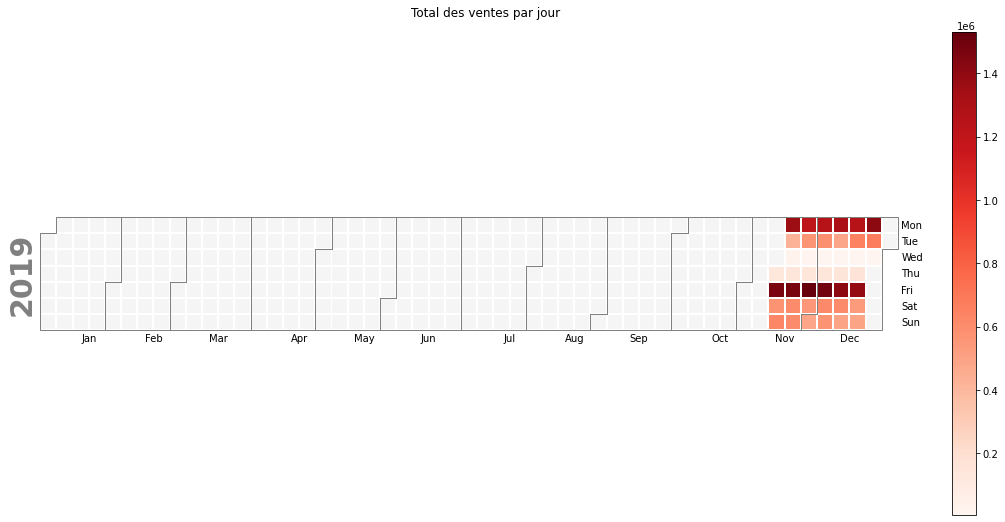

In [ ]:
calplot.calplot(data = df_group, how = 'sum',
                      cmap = 'Reds', figsize = (16, 7), suptitle = "Total des ventes par jour")

#### Heatmap des ventes pour toutes les machines par jour et par heure

In [ ]:
df_boisson2 = df_boisson.drop(columns=['product', 'machine', 'hour', 'year'])
df_boisson2

,date,day,h,num_day,month,period,count_coffee,count_soda,count_nrj,count_any,t_hours
10387,2019-12-23,Monday,0,23,12,Night,0,1,0,1,0h-1h
737,2019-11-16,Saturday,0,16,11,Night,0,1,0,1,0h-1h
7545,2019-12-13,Friday,0,13,12,Night,0,1,0,1,0h-1h
7544,2019-12-13,Friday,0,13,12,Night,0,1,0,1,0h-1h
7543,2019-12-13,Friday,0,13,12,Night,0,1,0,1,0h-1h
...,...,...,...,...,...,...,...,...,...,...,...
8374,2019-12-14,Saturday,23,14,12,Night,0,1,0,1,23h-24h
8375,2019-12-14,Saturday,23,14,12,Night,0,0,1,1,23h-24h
8376,2019-12-14,Saturday,23,14,12,Night,0,0,1,1,23h-24h
3675,2019-11-27,Wednesday,23,27,11,Night,0,0,1,1,23h-24h


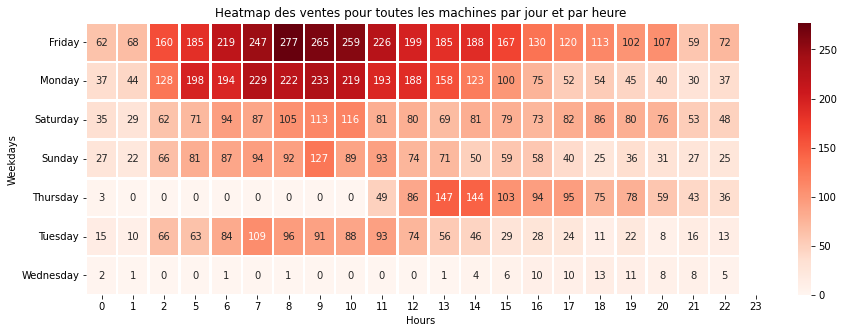

In [ ]:
df_boisson2 = df_boisson.drop(columns=['date', 'product', 'machine', 'period', 'count_coffee', 'count_soda', 'count_nrj', 'count_any', 't_hours', 'num_day', 'month', 'year'])
df_boisson2 = df_boisson2.pivot_table(index = "day", columns = "h", aggfunc = "count", fill_value = 0)

fig, hm = plt.subplots(figsize = (15, 5))

hm = sns.heatmap(data=df_boisson2, 
                   xticklabels=[0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # pas de 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True, fmt='g',
                   linewidths = 1.5)
hm = plt.title("Heatmap des ventes pour toutes les machines par jour et par heure")
hm = plt.xlabel("Hours")
hm = plt.ylabel("Weekdays")

plt.show()

Les distributeurs commencent sérieusement à se vider à partir du mardi après-midi.

### Graphiques

In [ ]:
df_boisson['h'] = df_boisson['h'].astype(int)

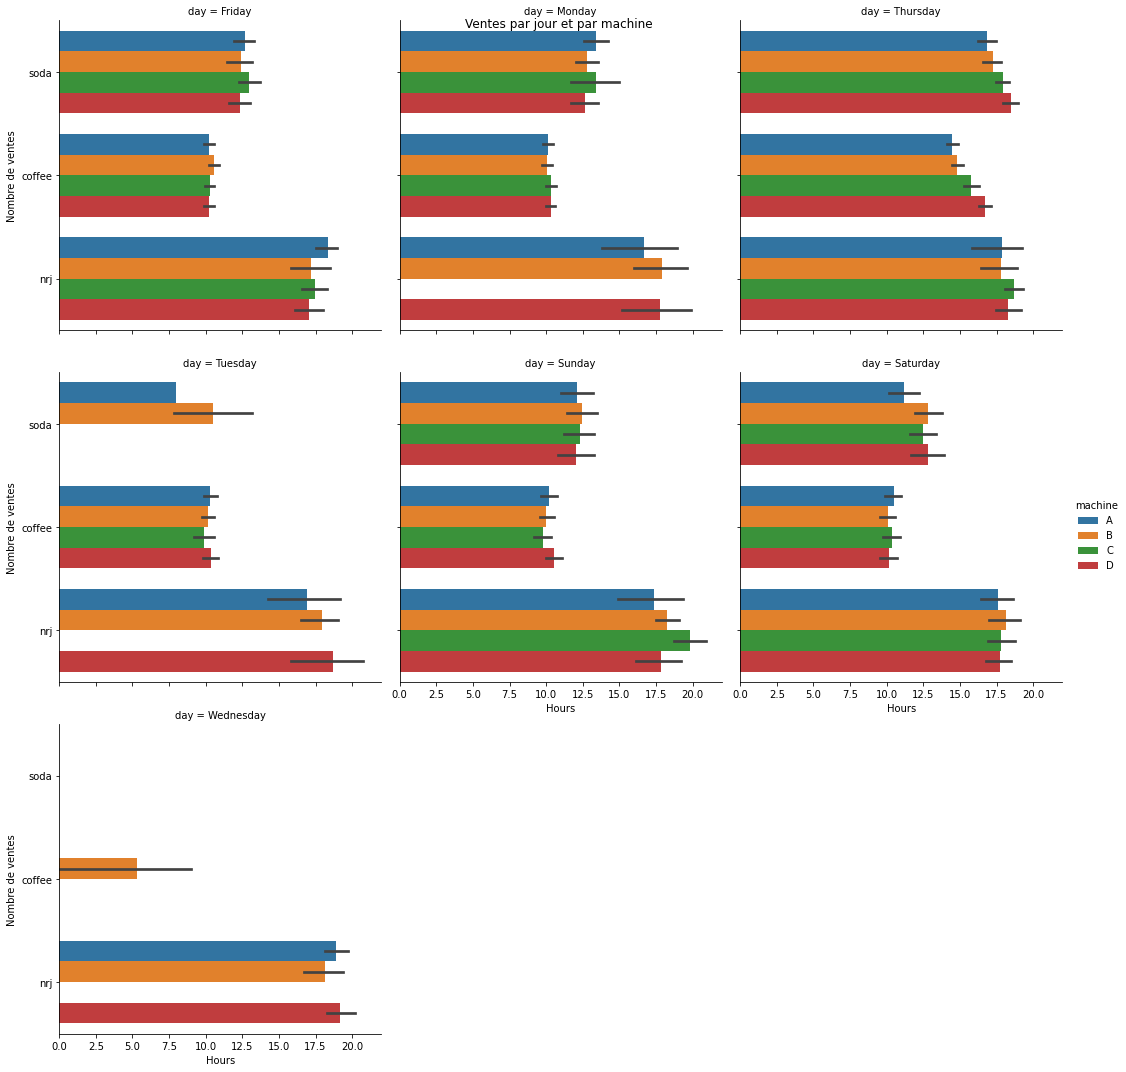

In [ ]:
ax = sns.catplot(data=df_boisson.sort_values(by=["machine"]), x = "h", y = "product", col = "day", col_wrap = 3, kind = "bar", hue = "machine")
ax.set(ylabel='Nombre de ventes', xlabel = 'Hours')
ax.fig.suptitle("Ventes par jour et par machine")

plt.show()

On voit clairement les ruptures de stocks par machine ici, qui ont lieu le mardi ou le mercredi.

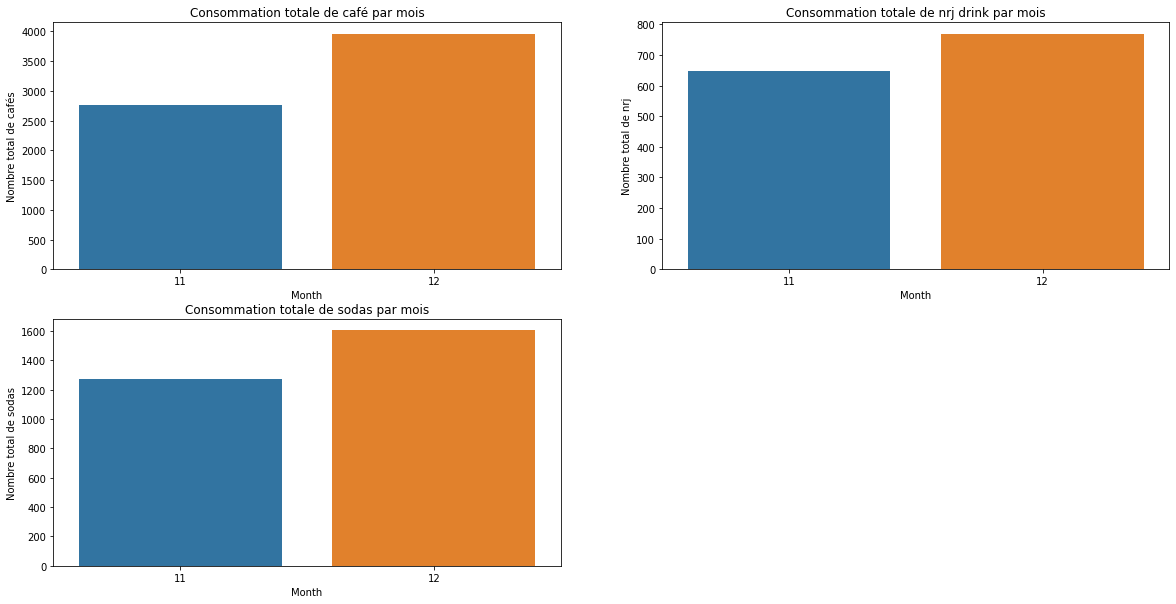

In [ ]:
plt.subplots(figsize = (20, 10))

plt.subplot(221)
sns.countplot(data=df_boisson[df_boisson['product'] == 'coffee'], x = "month")
plt.ylabel("Nombre total de cafés")
plt.xlabel("Month")
plt.title("Consommation totale de café par mois")

plt.subplot(222)
sns.countplot(data=df_boisson[df_boisson['product'] == 'nrj'], x = "month")
plt.ylabel("Nombre total de nrj")
plt.xlabel("Month")
plt.title("Consommation totale de nrj drink par mois")

plt.subplot(223)
sns.countplot(data=df_boisson[df_boisson['product'] == 'soda'], x = "month")
plt.ylabel("Nombre total de sodas")
plt.xlabel("Month")
plt.title("Consommation totale de sodas par mois")

plt.show()

In [ ]:
# Convertir date en str pour le graphique par date ci-dessous :

df_boisson['date'] = df_boisson['date'].astype(str)

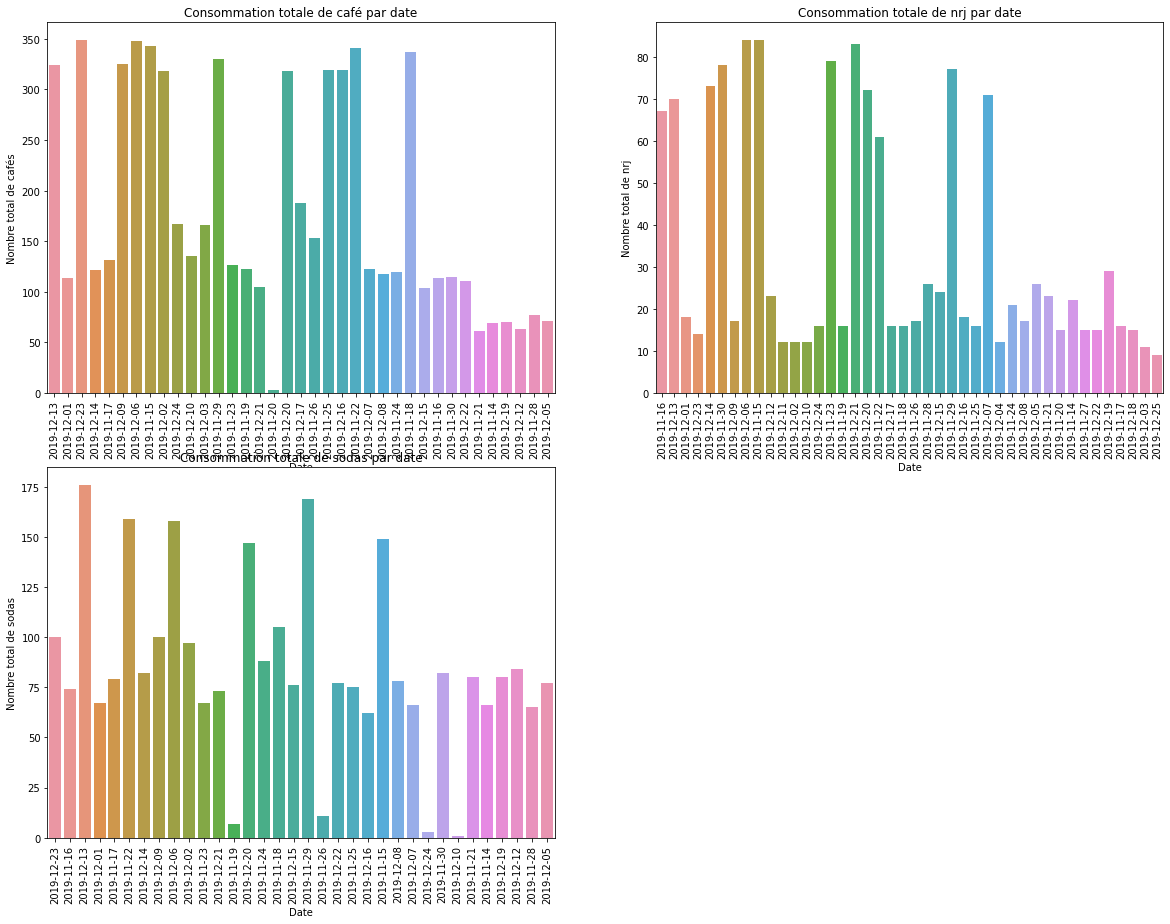

In [ ]:
plt.subplots(figsize = (20, 15))

plt.subplot(221)
sns.countplot(data=df_boisson[df_boisson['product'] == 'coffee'], x = "date")
plt.ylabel("Nombre total de cafés")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.title("Consommation totale de café par date")

plt.subplot(222)
sns.countplot(data=df_boisson[df_boisson['product'] == 'nrj'], x = "date")
plt.ylabel("Nombre total de nrj")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.title("Consommation totale de nrj par date")

plt.subplot(223)
sns.countplot(data=df_boisson[df_boisson['product'] == 'soda'], x = "date")
plt.ylabel("Nombre total de sodas")
plt.xlabel("Date")
plt.xticks(rotation=90)
plt.title("Consommation totale de sodas par date")


plt.show()

## Réorganisation :

In [ ]:
# Réorganisation du DF :

df_boisson = df_boisson[['date', 'day', 'num_day', 'month', 'year', 'product', 'machine', 'hour', 'h', 't_hours', 'period', 'count_coffee',	'count_soda', 'count_nrj', 'count_any']]
df_boisson

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any
10387,2019-12-23,Monday,23,12,2019,soda,D,00:19,0,0h-1h,Night,0,1,0,1
737,2019-11-16,Saturday,16,11,2019,soda,B,00:06,0,0h-1h,Night,0,1,0,1
7545,2019-12-13,Friday,13,12,2019,soda,C,00:52,0,0h-1h,Night,0,1,0,1
7544,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1
7543,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8374,2019-12-14,Saturday,14,12,2019,soda,B,23:44,23,23h-24h,Night,0,1,0,1
8375,2019-12-14,Saturday,14,12,2019,nrj,C,23:46,23,23h-24h,Night,0,0,1,1
8376,2019-12-14,Saturday,14,12,2019,nrj,B,23:51,23,23h-24h,Night,0,0,1,1
3675,2019-11-27,Wednesday,27,11,2019,nrj,B,23:59,23,23h-24h,Night,0,0,1,1


In [ ]:
# df_boisson.to_csv('boisson.csv', index=False)
# files.download('boisson.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Résumé :

- Dataframe compris entre le 14/11 et le 25/12/2019, soit 42 jours.
- Jour moyen de rupture de stock : Mardi après-midi
- Jour où les ventes soint les - hautes : Mercredi
- Jour où les ventes sont les + hautes : Vendredi
- Jour de recharge des distributeurs : Jeudi entre 12h et 15h
- Gare fermée entre 2 et 5 heures du matin chaque jour
- Tranches horaires où les ventes sont meilleures : le matin entre 9h et 12h
- Pas de réelle différence de ventes le week-end, elles sont ni excellentes ni mauvaises.
- C'est le café qui se vend le mieux dans ces distributeurs, et de loin (suivi des sodas).


# ANALYSE

## Analyse par prix et quantités

- Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.
- Le prix de vente des boissons est de : 1 euro le café ; 1,60 euros le soda ; 1,80 euros le nrj drink.
- Le coût de revient des boissons est de : 30 cts le café ; 60 cts le soda ; 80 cts le nrj drink.
- Chaque distributeur a une capacité maximale de : 280 doses de café ; 120 canettes de soda ; 60 bouteilles de nrj drink.
- La gare est fermée au public une partie de la nuit.
- Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
- Les frais d'entretien de chaque machine sont de 1200 euros annuels.

In [ ]:
# Déplacement employé :

tech_cost = 50
tech_mach_cost = 20

# Prix :

coffee_price = 1
soda_price = 1.6
nrj_price = 1.8

# Couts :

coffee_cost = 0.3
soda_cost = 0.6
nrj_cost = 0.8

# Capacités des machines :

coffee_cap = 280
soda_cap = 120
nrj_cap = 60

# Location et entretien des machines :

machine_monthly_space_rental = 150
machine_yearly_upkeep_cost = 1200

### Coût du déplacement de l'employé par semaine

In [ ]:
cost_employee = tech_cost + (tech_mach_cost * 4) # déplacement gare 50 € + 20 par machine (donc * 4)
cost_employee

130

### Capacités maximales de chaque machine pour la semaine

In [ ]:
print("Les 4 distributeurs ont la possibilité de vendre au maximum à chaque recharge pour une semaine :")
print(coffee_cap * 4, 'coffee')
print(soda_cap * 4, 'soda')
print(nrj_cap * 4, 'nrj drink')

Les 4 distributeurs ont la possibilité de vendre au maximum à chaque recharge pour une semaine :
1120 coffee
480 soda
240 nrj drink


In [ ]:
total = print('Total de tous les produits possibles de vendre par semaine : ', coffee_cap * 4 + soda_cap * 4 + nrj_cap * 4)

Total de tous les produits possibles de vendre par semaine :  1840


In [ ]:
moy = ((coffee_cap * 4 + soda_cap * 4 + nrj_cap * 4) / 3)
moy

613.3333333333334

In [ ]:
moy = print('Moyenne de tous les produits possibles de vendre par semaine : ', round((coffee_cap * 4 + soda_cap * 4 + nrj_cap * 4) / 3, 2)) # 3 car 3 produits

Moyenne de tous les produits possibles de vendre par semaine :  613.33


### Total et moyenne par machine

In [ ]:
# Dépenses & revenus des 4 machines avec 1 rechargement par semaine et par machine :

val_counts = df_boisson.groupby(by = "product").count()['date']

nb_deplacements = df_refill.groupby(by="product").count()['date'][0]

# (( Déplacement employés + (main d'oeuvre x 4 machines) x nombre de déplacements) + (location emplacement x 4 machines)) :
dep_tot = ((50 + (4 * 20)) * nb_deplacements) + (150 * 4)                        

nb_cafe = val_counts[0]
nb_nrj = val_counts[1]
nb_soda = val_counts[2]

# Nombre de produits vendus x prix de revient du produit pour chaque produit :
revenus = (nb_cafe * coffee_cost) + (nb_soda * soda_cost) + (nb_nrj * nrj_cost)                           

print("Total des dépenses des machines = {} €".format(dep_tot))
print("Total des revenus des machines = {} €\n".format(revenus))

print("Moyenne des dépenses des machines = {} €".format(dep_tot / 6))
print("Moyenne des revenus des machines = {} €".format(round(revenus / 6, 2)))

Total des dépenses des machines = 3720 €
Total des revenus des machines = 4878.4 €

Moyenne des dépenses des machines = 620.0 €
Moyenne des revenus des machines = 813.07 €


### Total des quantités vendues par boisson

In [ ]:
print(val_counts)

product
coffee    6720
nrj       1418
soda      2880
Name: date, dtype: int64


### CA sur les 2 mois

In [ ]:
# Chiffre d'affaires total par produit et sa représentation en pourcentage :

ca_coffee = print("Cafés :", (df_boisson[df_boisson['product']=='coffee']['product'].count()) * coffee_price, '€', "soit", (df_boisson['product'].value_counts()[0]/len(df_boisson)*100).round(2), "% des ventes.")
ca_soda = print("Sodas :", (df_boisson[df_boisson['product']=='soda']['product'].count()) * soda_price, '€', "soit", (df_boisson['product'].value_counts()[1]/len(df_boisson)*100).round(2), "% des ventes.")
ca_nrj = print("Nrj drink :", (df_boisson[df_boisson['product']=='nrj']['product'].count())* nrj_price, '€', "soit", (df_boisson['product'].value_counts()[2]/len(df_boisson)*100).round(2), "% des ventes.")

Cafés : 6720 € soit 60.99 % des ventes.
Sodas : 4608.0 € soit 26.14 % des ventes.
Nrj drink : 2552.4 € soit 12.87 % des ventes.


In [ ]:
ca_total = print("CA Total :", 6720 + 4608 + 2552.4, '€')
ca_total

CA Total : 13880.4 €


### Coût de revient

In [ ]:
# Coût de revient :

print("Le coût de revient pour le café est de :", (df_boisson[df_boisson['product']=='coffee']['product'].count())*coffee_cost, '€')
print("Le coût de revient pour le soda est de :", (df_boisson[df_boisson['product']=='soda']['product'].count())*soda_cost, '€')
print("Le coût de revient pour le nrj drink est de :", (df_boisson[df_boisson['product']=='nrj']['product'].count())*nrj_cost, '€')

Le coût de revient pour le café est de : 2016.0 €
Le coût de revient pour le soda est de : 1728.0 €
Le coût de revient pour le nrj drink est de : 1134.4 €


In [ ]:
print("Pour un coût de revient total de", ((df_boisson[df_boisson['product']=='coffee']['product'].count())*coffee_cost) + ((df_boisson[df_boisson['product']=='soda']['product'].count())*soda_cost) + ((df_boisson[df_boisson['product']=='nrj']['product'].count())*nrj_cost), '€ ces deux mois.')

Pour un coût de revient total de 4878.4 € sur novembre et décembre 2019


### Profit

In [ ]:
coffee_profit = ((df_boisson[df_boisson['product']=='coffee']['product'].count())*1)-((df_boisson[df_boisson['product']=='coffee']['product'].count())*coffee_cost)
print("Profit réalisé pour le café :", coffee_profit, "€")

Profit réalisé pour le café : 4704.0 €


In [ ]:
soda_profit = ((df_boisson[df_boisson['product']=='soda']['product'].count())*1.60)-((df_boisson[df_boisson['product']=='soda']['product'].count())*soda_cost)
print("Profit réalisé pour le soda :", soda_profit, "€")

Profit réalisé pour le soda : 2880.0 €


In [ ]:
nrj_profit = ((df_boisson[df_boisson['product']=='nrj']['product'].count())*1.80)-((df_boisson[df_boisson['product']=='nrj']['product'].count())*nrj_cost)
print("Profit réalisé pour le Nrj drink :", nrj_profit, "€")

Profit réalisé pour le Nrj drink : 1418.0 €


In [ ]:
profit_total = coffee_profit + soda_profit + nrj_profit
print("Profit total :", profit_total, "€")

Profit total : 9002.0 €


# ANALYSE DE CONSOMMATION ET DE STOCKS

### Ventes en semaine / week-end

#### Semaine

In [ ]:
week = df_boisson[(df_boisson['day'] != 'Saturday') & (df_boisson['day'] != 'Sunday')]
week

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any
10387,2019-12-23,Monday,23,12,2019,soda,D,00:19,0,0h-1h,Night,0,1,0,1
7545,2019-12-13,Friday,13,12,2019,soda,C,00:52,0,0h-1h,Night,0,1,0,1
7544,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1
7543,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1
7542,2019-12-13,Friday,13,12,2019,soda,B,00:35,0,0h-1h,Night,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3842,2019-11-28,Thursday,28,11,2019,soda,A,23:23,23,23h-24h,Night,0,1,0,1
3841,2019-11-28,Thursday,28,11,2019,coffee,B,23:17,23,23h-24h,Night,1,0,0,1
3840,2019-11-28,Thursday,28,11,2019,soda,C,23:03,23,23h-24h,Night,0,1,0,1
3675,2019-11-27,Wednesday,27,11,2019,nrj,B,23:59,23,23h-24h,Night,0,0,1,1


In [ ]:
print("Coffee :", week[week['product']=='coffee']['product'].count(), "€ soit", (week['product'].value_counts()[0]/len(week)*100).round(2), "%")

print("Soda :", week[week['product']=='soda']['product'].count(), "€ soit", (week['product'].value_counts()[1]/len(week)*100).round(2), "%")

print("Nrj drink :", week[week['product']=='nrj']['product'].count(), "€ soit", (week['product'].value_counts()[2]/len(week)*100).round(2), "%")


Coffee : 5317 € soit 65.29 %
Soda : 1971 € soit 24.2 %
Nrj drink : 856 € soit 10.51 %


In [ ]:
df_week = week[week['product'] != 'refill']
period_week = df_week.pivot_table(df_week, index = 'period', columns = 'product', aggfunc = 'count')
period_week.drop(columns=['date', 'num_day', 'month', 'year', 'machine', 'hour', 'h', 't_hours', 'count_coffee', 'count_soda', 'count_nrj', 'count_any'], inplace = True)
period_week.rename(columns={'day': 'Quantités vendues en semaine'}, inplace = True)
period_week

Quantités vendues en semaine          
product                         coffee  nrj soda
period                                          
Afternoon                         1480  218  643
Evening                            164  457  426
Morning                           3523   13  659
Night                              150  168  243

In [ ]:
df_week = week[week['product'] != 'refill']
mach_week = df_week.pivot_table(df_week, index = ['period', 'machine'], columns = 'product', aggfunc = 'count')
mach_week.drop(columns=['date', 'num_day', 'month', 'year', 'hour', 'h', 't_hours', 'count_coffee', 'count_soda', 'count_nrj', 'count_any'], inplace = True)
mach_week.rename(columns={'day': 'Quantités vendues en semaine'}, inplace = True)
mach_week

Quantités vendues en semaine          
product                                 coffee  nrj soda
period    machine                                       
Afternoon A                                370   57  184
          B                                396   55  166
          C                                344   53  147
          D                                370   53  146
Evening   A                                 36  109   98
          B                                 40  132  101
          C                                 45  122  113
          D                                 43   94  114
Morning   A                                912    3  180
          B                                839    4  162
          C                                869    2  136
          D                                903    4  181
Night     A                                 41   37   57
          B                                 29   51   51
          C                                 41   28   61
          D                                 39   52   74

#### Week-end

In [ ]:
week_end = df_boisson[(df_boisson['day'] == 'Saturday') | (df_boisson['day'] == 'Sunday')]
week_end

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any
737,2019-11-16,Saturday,16,11,2019,soda,B,00:06,0,0h-1h,Night,0,1,0,1
738,2019-11-16,Saturday,16,11,2019,nrj,D,00:11,0,0h-1h,Night,0,0,1,1
4700,2019-12-01,Sunday,1,12,2019,nrj,A,00:12,0,0h-1h,Night,0,0,1,1
4701,2019-12-01,Sunday,1,12,2019,soda,B,00:23,0,0h-1h,Night,0,1,0,1
4702,2019-12-01,Sunday,1,12,2019,coffee,C,00:38,0,0h-1h,Night,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,2019-12-14,Saturday,14,12,2019,nrj,A,23:29,23,23h-24h,Night,0,0,1,1
8373,2019-12-14,Saturday,14,12,2019,nrj,A,23:39,23,23h-24h,Night,0,0,1,1
8374,2019-12-14,Saturday,14,12,2019,soda,B,23:44,23,23h-24h,Night,0,1,0,1
8375,2019-12-14,Saturday,14,12,2019,nrj,C,23:46,23,23h-24h,Night,0,0,1,1


In [ ]:
print("Coffee :", week_end[week_end['product']=='coffee']['product'].count(), "€ soit", (week_end['product'].value_counts()[0]/len(week_end)*100).round(2), "%")

print("Soda :", week_end[week_end['product']=='soda']['product'].count(), "€ soit", (week_end['product'].value_counts()[1]/len(week_end)*100).round(2), "%")

print("Nrj drink :", week_end[week_end['product']=='nrj']['product'].count(), "€ soit", (week_end['product'].value_counts()[2]/len(week_end)*100).round(2), "%")

Coffee : 1403 € soit 48.82 %
Soda : 909 € soit 31.63 %
Nrj drink : 562 € soit 19.55 %


In [ ]:
df_week_end = week_end[week_end['product'] != 'refill']
period_week = df_week_end.pivot_table(df_week_end, index = 'period', columns = 'product', aggfunc = 'count')
period_week.drop(columns=['date', 'num_day', 'month', 'year', 'machine', 'hour', 'h', 't_hours', 'count_coffee', 'count_soda', 'count_nrj', 'count_any'], inplace = True)
period_week.rename(columns={'day': 'Quantités vendues en semaine'}, inplace = True)
period_week

Quantités vendues en semaine          
product                         coffee  nrj soda
period                                          
Afternoon                          308  139  247
Evening                             34  298  124
Morning                           1023    7  428
Night                               38  118  110

In [ ]:
df_week_end = week_end[week_end['product'] != 'refill']
mach_week = df_week_end.pivot_table(df_week, index = ['period', 'machine'], columns = 'product', aggfunc = 'count')
mach_week.drop(columns=['date', 'num_day', 'month', 'year', 'hour', 'h', 't_hours', 'count_coffee', 'count_soda', 'count_nrj', 'count_any'], inplace = True)
mach_week.rename(columns={'day': 'Quantités vendues en semaine'}, inplace = True)
mach_week

Quantités vendues en semaine         
product                                 coffee nrj soda
period    machine                                      
Afternoon A                                 75  34   52
          B                                 76  31   74
          C                                 72  34   77
          D                                 85  40   44
Evening   A                                 11  64   25
          B                                  5  65   31
          C                                 12  84   33
          D                                  6  85   35
Morning   A                                229   3  105
          B                                283   1  109
          C                                284   1  121
          D                                227   2   93
Night     A                                  6  39   19
          B                                 12  14   26
          C                                 13  36   32
          D                                  7  29   33

### Quels pourcentages et prix représentent les ruptures de stock ?

Rappel : ruptures de stock des produits : du mardi après-midi au jeudi après-midi (jour de recharge)

Résultat : 2 jours de perte !

In [ ]:
per = round(100 * 2 / 7, 2)
per

28.57

In [ ]:
# Pourcentage :

per = print("Ces deux jours representent {} % des ventes perdues !".format(round(100 * 2 / 7, 2))) # 2 jours de perte / 7 jours par semaine

Ces deux jours representent 28.57 % des ventes perdues !


In [ ]:
mean = ((coffee_cost + soda_cost + nrj_cost) / 3)
mean

0.5666666666666667

In [ ]:
# Moyenne de prix des 3 produits :

mean = print("Cela reprsente {} € de moyenne de prix des 3 produits".format(round(((coffee_cost + soda_cost + nrj_cost) / 3), 2)))

Cela reprsente 0.57 € de moyenne de prix des 3 produits


In [ ]:
prix_semaine = 613.33 * 0.2857 * 0.57 # Quantités moyennes vendues * pourcentage des ventes lors de ruptures * prix du produit en rupture
prix_semaine # Manque à gagner à cause des ruptures de stock : 99,9 € par semaine

99.88017717

In [ ]:
print("Cela représente {} € par mois".format(round(prix_semaine * 4, 2))) # Presque 400 € par mois de perdus !

Cela représente 399.52 € par mois


### Un rechargement supplémentaire par semaine serait-il rentable ?

In [ ]:
# Moyenne des dépenses des machines = 620.0 €
# Moyenne des revenus des machines = 813.07 €

revenu_possible = revenus + prix_semaine
depense_possible = dep_tot + 4 * 20

print("Revenus possibles par semaine  = {}€".format(revenu_possible))
print("Dépenses possibles par semaine  = {}€".format(depense_possible))
print("Par mois, avec en + la location d'emplacement:\n\nRevenus = {}€\Dépenses = {}€".format(revenu_possible * 4, 150 + depense_possible * 4))
print("A l'année, en plus de l'entretien et de la location :\n\nRevenus = {}€\nDépenses = {}€".format(revenu_possible * 52, 150 * 12 + 1200 + depense_possible * 52))

Il est donc possible de faire 2 rechargements par semaine : celui du jeudi, qui est à garder, et un autre le lundi par exemple.

## Analyse détaillée par machine (ne pas relancer systématiquement)

In [ ]:
# Pour Machine A, B, C, D seulement (ne marche pas pour Stocks restants)

refill_A = df_boisson[df_boisson['machine'] == 'A'].copy(deep=True)
refill_B = df_boisson[df_boisson['machine'] == 'B'].copy(deep=True)
refill_C = df_boisson[df_boisson['machine'] == 'C'].copy(deep=True)
refill_D = df_boisson[df_boisson['machine'] == 'D'].copy(deep=True)

### Machine A

In [ ]:
# Ventes, revenus et stocks max pour chaque machine :

refill_A.reset_index(drop=True, inplace=True)

refill_A['sales'] = refill_A.groupby('product').cumcount() + 1 # ventes
refill_A['revenue'] = refill_A.apply(lambda x: x['sales'] * (coffee_price - coffee_cost) # prix - cout de chaque boisson
                                        if x['product'] == 'coffee' 
                                            else x['sales'] * (soda_price - soda_cost) 
                                                if x['product'] == 'soda' 
                                                    else x['sales'] * (nrj_price - nrj_cost) 
                                                        if x['product'] == 'nrj' else np.NaN, axis = 1) # revenus

refill_A['max_stock'] = refill_A['product'].apply(lambda x: coffee_cap 
                                                    if x == 'coffee' 
                                                        else soda_cap 
                                                            if x == 'soda' 
                                                                else nrj_cap 
                                                                    if x == 'nrj' 
                                                                        else np.NaN) # stocks max par boisson

In [ ]:
refill_A

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,2019-12-01,Sunday,1,12,2019,nrj,A,00:12,0,0h-1h,Night,0,0,1,1,1,1.0,60
1,2019-12-13,Friday,13,12,2019,soda,A,00:19,0,0h-1h,Night,0,1,0,1,1,1.0,120
2,2019-12-01,Sunday,1,12,2019,nrj,A,00:00,0,0h-1h,Night,0,0,1,1,2,2.0,60
3,2019-11-16,Saturday,16,11,2019,nrj,A,00:28,0,0h-1h,Night,0,0,1,1,3,3.0,60
4,2019-12-23,Monday,23,12,2019,coffee,A,00:30,0,0h-1h,Night,1,0,0,1,1,0.7,280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2741,2019-11-23,Saturday,23,11,2019,nrj,A,23:43,23,23h-24h,Night,0,0,1,1,344,344.0,60
2742,2019-11-14,Thursday,14,11,2019,soda,A,23:07,23,23h-24h,Night,0,1,0,1,719,719.0,120
2743,2019-11-28,Thursday,28,11,2019,soda,A,23:23,23,23h-24h,Night,0,1,0,1,720,720.0,120
2744,2019-12-14,Saturday,14,12,2019,nrj,A,23:29,23,23h-24h,Night,0,0,1,1,345,345.0,60


In [ ]:
# Tableau des jours sur la machine A :

df_days_A = refill_A.groupby(['day', 'product']).count().reset_index()
df_days_A

,day,product,date,num_day,month,year,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,Friday,coffee,486,486,486,486,486,486,486,486,486,486,486,486,486,486,486,486
1,Friday,nrj,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104
2,Friday,soda,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234,234
3,Monday,coffee,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457,457
4,Monday,nrj,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
5,Monday,soda,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
6,Saturday,coffee,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167,167
7,Saturday,nrj,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114,114
8,Saturday,soda,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92,92
9,Sunday,coffee,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154,154


In [ ]:
fig = px.bar(df_days_A, x='day', y="count_any", color="product", text="product", 
             category_orders={"product": ["coffee", "nrj", "soda"], "day": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}, 
             title = 'Total des ventes par jour sur le distributeur A',
             labels = {'day': ' ', "count_any":"Ventes"},
             )
fig.update_layout(showlegend=False, title_x=0.5)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
# Pivot table nombre de cafés vendus par heure et par jour :

index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
coffee_a = refill_A.pivot_table(index=['day'], columns='h', values='count_coffee', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
coffee_a.replace(np.NaN, 0, inplace=True)
coffee_a

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,5.0,6.0,0.0,0.0,0.0,29.0,32.0,40.0,50.0,53.0,...,29.0,17.0,19.0,7.0,6.0,0.0,3.0,1.0,2.0,2.0
Tuesday,2.0,2.0,0.0,0.0,0.0,11.0,22.0,27.0,29.0,30.0,...,10.0,7.0,10.0,6.0,5.0,0.0,2.0,1.0,2.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,25.0,16.0,6.0,3.0,2.0,1.0,1.0,4.0,1.0
Friday,3.0,8.0,0.0,0.0,0.0,31.0,31.0,46.0,46.0,66.0,...,26.0,30.0,17.0,8.0,3.0,3.0,2.0,3.0,0.0,4.0
Saturday,0.0,2.0,0.0,0.0,0.0,5.0,13.0,18.0,16.0,19.0,...,11.0,4.0,9.0,3.0,4.0,2.0,1.0,1.0,0.0,0.0
Sunday,0.0,4.0,0.0,0.0,0.0,11.0,5.0,9.0,18.0,19.0,...,13.0,3.0,6.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0


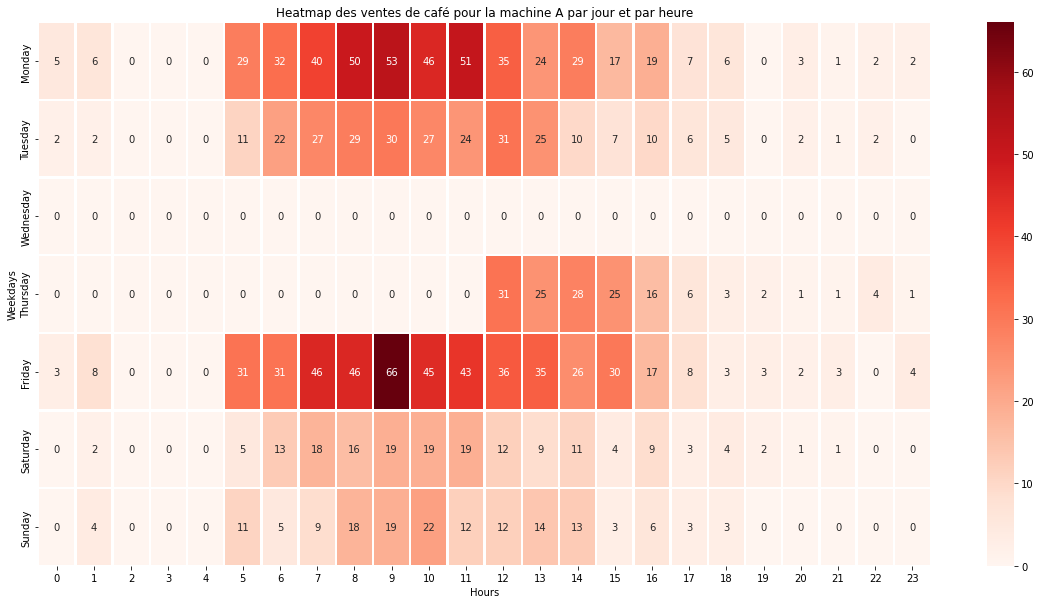

In [ ]:
plt.subplots(figsize = (20, 10))

hm2 = sns.heatmap(data=coffee_a, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm2 = plt.title("Heatmap des ventes de café pour la machine A par jour et par heure")
hm2 = plt.xlabel("Hours")
hm2 = plt.ylabel("Weekdays")

In [ ]:
# Pivot nombre de sodas vendus par heure et par jour :

index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
soda_a = refill_A.pivot_table(index=['day'], columns='h', values='count_soda', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
soda_a.replace(np.NaN, 0, inplace=True)
soda_a

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,2.0,4.0,0.0,0.0,0.0,6.0,8.0,5.0,7.0,7.0,...,14.0,10.0,7.0,13.0,5.0,8.0,5.0,5.0,5.0,9.0
Tuesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14.0,11.0,12.0,6.0,10.0,9.0,14.0,10.0,6.0,7.0
Friday,3.0,6.0,0.0,0.0,0.0,13.0,12.0,13.0,11.0,11.0,...,19.0,18.0,13.0,10.0,12.0,9.0,7.0,4.0,7.0,8.0
Saturday,2.0,2.0,0.0,0.0,0.0,8.0,5.0,7.0,5.0,12.0,...,3.0,6.0,4.0,5.0,2.0,4.0,0.0,2.0,1.0,3.0
Sunday,3.0,3.0,0.0,0.0,0.0,8.0,7.0,5.0,9.0,4.0,...,5.0,7.0,4.0,7.0,5.0,4.0,4.0,4.0,3.0,2.0


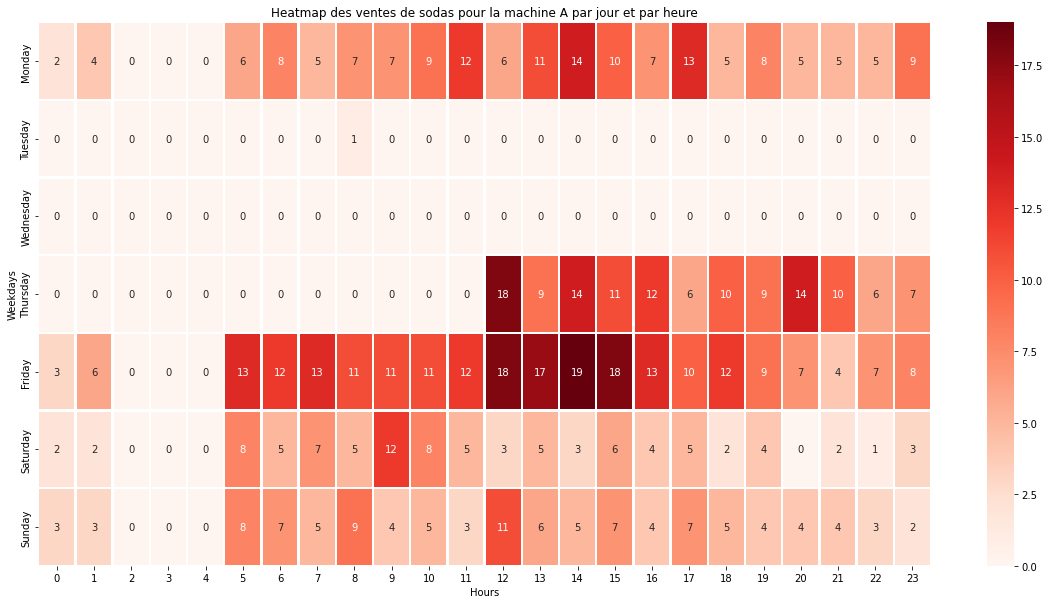

In [ ]:
plt.subplots(figsize = (20, 10))

hm3 = sns.heatmap(data=soda_a, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm3 = plt.title("Heatmap des ventes de sodas pour la machine A par jour et par heure")
hm3 = plt.xlabel("Hours")
hm3 = plt.ylabel("Weekdays")

In [ ]:
# Pivot nombre de nrj drink vendus par heure et par jour :

index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
nrj_a = refill_A.pivot_table(index=['day'], columns='h', values='count_nrj', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
nrj_a.replace(np.NaN, 0, inplace=True)
nrj_a

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,2.0,2.0,4.0,2.0,4.0,0.0,3.0
Tuesday,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,3.0,4.0,1.0,1.0,2.0,5.0,3.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,2.0,3.0,5.0,4.0,5.0,2.0,0.0
Thursday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0
Friday,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,3.0,10.0,12.0,11.0,18.0,15.0,15.0,5.0,6.0
Saturday,6.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,5.0,7.0,11.0,12.0,14.0,15.0,12.0,14.0,10.0
Sunday,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,3.0,0.0,2.0,7.0,2.0,3.0,1.0


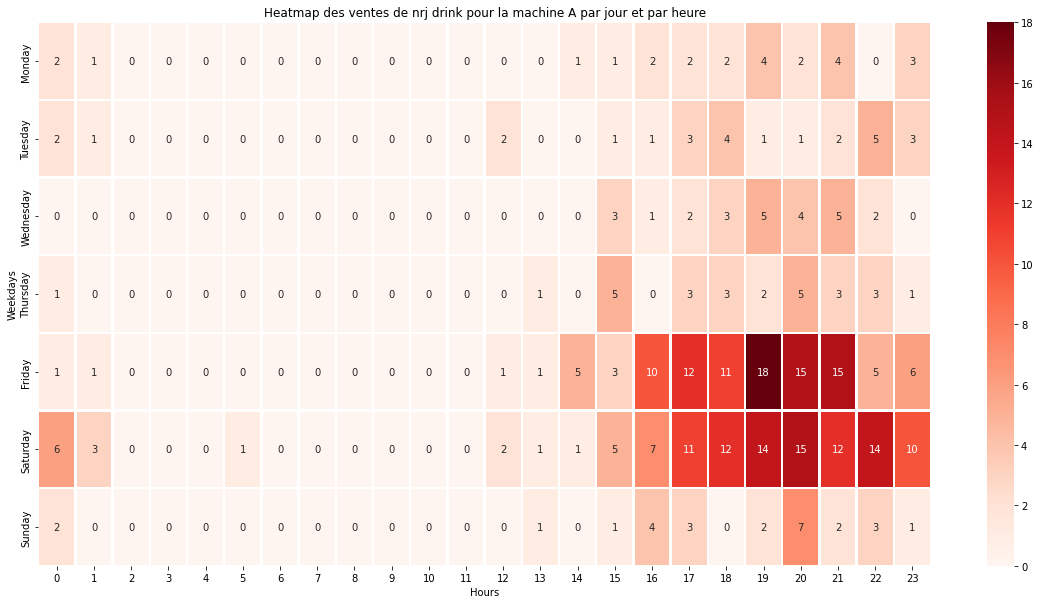

In [ ]:
plt.subplots(figsize = (20, 10))

hm4 = sns.heatmap(data=nrj_a, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm4 = plt.title("Heatmap des ventes de nrj drink pour la machine A par jour et par heure")
hm4 = plt.xlabel("Hours")
hm4 = plt.ylabel("Weekdays")

### Machine B

In [ ]:
refill_B.reset_index(drop = True, inplace = True)

refill_B['sales'] = refill_B.groupby('product').cumcount() + 1
refill_B['revenue'] = refill_B.apply(lambda x: x['sales'] * (coffee_price - coffee_cost) if x['product'] == 'coffee' else x['sales'] * (soda_price - soda_cost) if x['product'] == 'soda' else x['sales'] * (nrj_price - nrj_cost) if x['product'] == 'nrj' else np.NaN, axis=1)
refill_B['max_stock'] = refill_B['product'].apply(lambda x: coffee_cap if x == 'coffee' else soda_cap if x == 'soda' else nrj_cap if x == 'nrj' else np.NaN)

In [ ]:
refill_B

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,2019-11-14,refill,B,12:47,Thursday,12,14,11,2019,Morning,0,0,0,0,1,NaN,NaN
1,2019-11-21,refill,B,13:33,Thursday,13,21,11,2019,Afternoon,0,0,0,0,2,NaN,NaN
2,2019-11-28,refill,B,12:54,Thursday,12,28,11,2019,Morning,0,0,0,0,3,NaN,NaN
3,2019-12-05,refill,B,12:54,Thursday,12,5,12,2019,Morning,0,0,0,0,4,NaN,NaN
4,2019-12-12,refill,B,12:55,Thursday,12,12,12,2019,Morning,0,0,0,0,5,NaN,NaN
5,2019-12-19,refill,B,13:06,Thursday,13,19,12,2019,Afternoon,0,0,0,0,6,NaN,NaN


In [ ]:
# Tableau des jours sur la machine B :

df_days_B = refill_B.groupby(['day', 'product']).count().reset_index()
df_days_B

,day,product,date,num_day,month,year,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,Friday,coffee,436,436,436,436,436,436,436,436,436,436,436,436,436,436,436,436
1,Friday,nrj,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64,64
2,Friday,soda,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175
3,Monday,coffee,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439,439
4,Monday,nrj,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45
5,Monday,soda,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
6,Saturday,coffee,189,189,189,189,189,189,189,189,189,189,189,189,189,189,189,189
7,Saturday,nrj,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67,67
8,Saturday,soda,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120
9,Sunday,coffee,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187


In [ ]:
fig = px.bar(df_days_B, x='day', y="count_any", color="product", text="product", 
             category_orders={"product": ["coffee", "nrj", "soda"], "day": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}, 
             title = 'Total des ventes par jour sur le distributeur B',
             labels = {'day': ' ', "count_any":"Ventes"},
             )
fig.update_layout(showlegend=False, title_x=0.5)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
coffee_b = refill_B.pivot_table(index=['day'], columns='h', values='count_coffee', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
coffee_b.replace(np.NaN, 0, inplace=True)
coffee_b

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,3.0,6.0,0.0,0.0,0.0,30.0,38.0,41.0,45.0,35.0,...,22.0,21.0,8.0,6.0,5.0,3.0,5.0,0.0,1.0,2.0
Tuesday,0.0,3.0,0.0,0.0,0.0,23.0,16.0,24.0,40.0,30.0,...,16.0,16.0,4.0,3.0,4.0,2.0,2.0,1.0,0.0,1.0
Wednesday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.0,19.0,15.0,8.0,4.0,0.0,2.0,2.0,0.0,3.0
Friday,5.0,2.0,0.0,0.0,0.0,22.0,27.0,40.0,45.0,39.0,...,31.0,19.0,20.0,16.0,5.0,0.0,4.0,1.0,2.0,0.0
Saturday,1.0,2.0,0.0,0.0,0.0,13.0,14.0,21.0,16.0,16.0,...,9.0,8.0,4.0,3.0,0.0,1.0,0.0,1.0,0.0,3.0
Sunday,1.0,5.0,0.0,0.0,0.0,7.0,14.0,18.0,18.0,19.0,...,12.0,5.0,7.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0


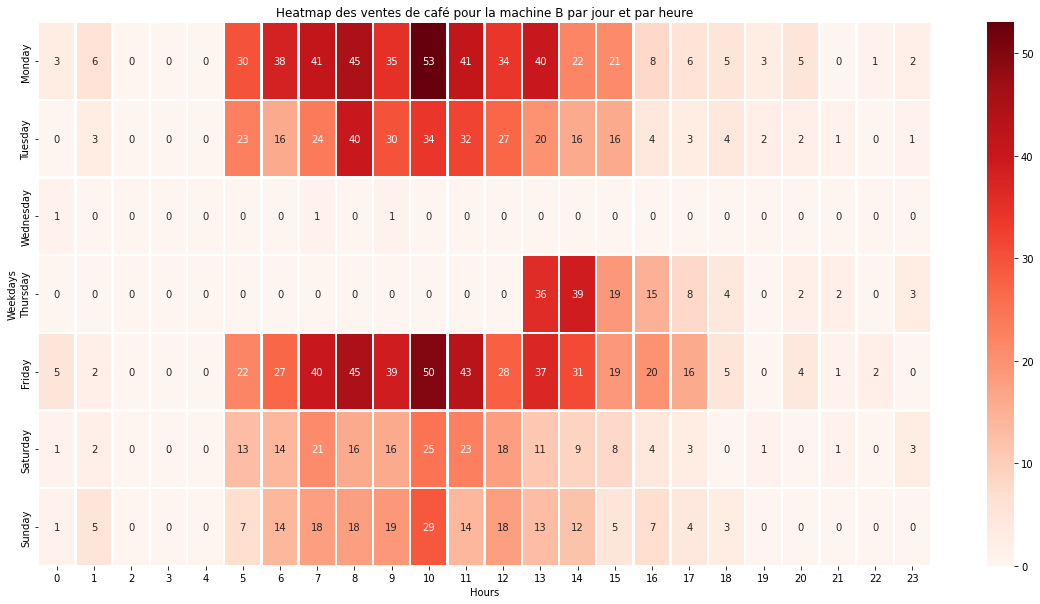

In [ ]:
plt.subplots(figsize = (20, 10))

hm5 = sns.heatmap(data=coffee_b, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm5 = plt.title("Heatmap des ventes de café pour la machine B par jour et par heure")
hm5 = plt.xlabel("Hours")
hm5 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
soda_b = refill_B.pivot_table(index=['day'], columns='h', values='count_soda', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
soda_b.replace(np.NaN, 0, inplace=True)
soda_b

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,3.0,3.0,0.0,0.0,0.0,5.0,10.0,10.0,9.0,14.0,...,11.0,14.0,14.0,7.0,8.0,9.0,6.0,4.0,6.0,4.0
Tuesday,2.0,1.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,3.0,...,1.0,1.0,1.0,1.0,0.0,1.0,3.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,13.0,8.0,9.0,12.0,8.0,9.0,9.0,10.0,1.0
Friday,6.0,8.0,0.0,0.0,0.0,9.0,3.0,9.0,12.0,8.0,...,7.0,11.0,13.0,7.0,8.0,9.0,7.0,8.0,3.0,4.0
Saturday,1.0,3.0,0.0,0.0,0.0,6.0,5.0,2.0,6.0,5.0,...,9.0,8.0,9.0,5.0,7.0,3.0,1.0,4.0,3.0,5.0
Sunday,6.0,1.0,0.0,0.0,0.0,6.0,8.0,6.0,2.0,6.0,...,9.0,5.0,12.0,5.0,5.0,1.0,5.0,5.0,3.0,4.0


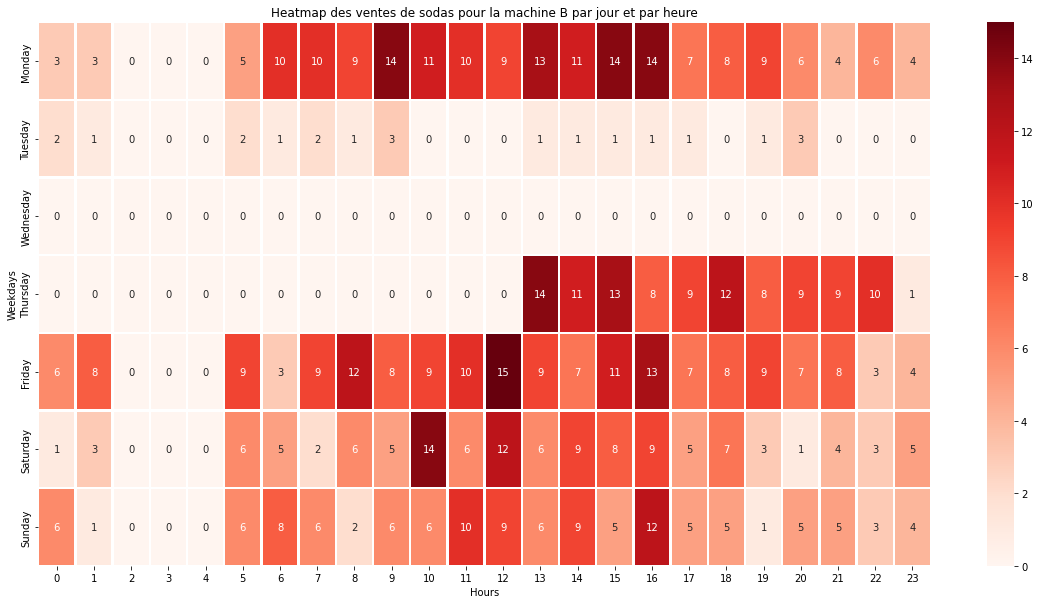

In [ ]:
plt.subplots(figsize = (20, 10))

hm6 = sns.heatmap(data=soda_b, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm6 = plt.title("Heatmap des ventes de sodas pour la machine B par jour et par heure")
hm6 = plt.xlabel("Hours")
hm6 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
nrj_b = refill_B.pivot_table(index=['day'], columns='h', values='count_nrj', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
nrj_b.replace(np.NaN, 0, inplace=True)
nrj_b

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2.0,5.0,9.0,9.0,7.0,4.0,3.0
Tuesday,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,3.0,6.0,9.0,5.0,6.0,2.0,5.0,3.0
Wednesday,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,4.0,8.0,4.0,6.0,4.0,2.0,5.0,5.0
Thursday,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,0.0,6.0,10.0,10.0,6.0,5.0,3.0,0.0
Friday,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,6.0,7.0,6.0,8.0,10.0,9.0,5.0,3.0
Saturday,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,6.0,5.0,10.0,5.0,14.0,10.0,3.0,5.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,3.0,4.0,4.0,8.0,5.0,5.0,8.0,2.0,1.0


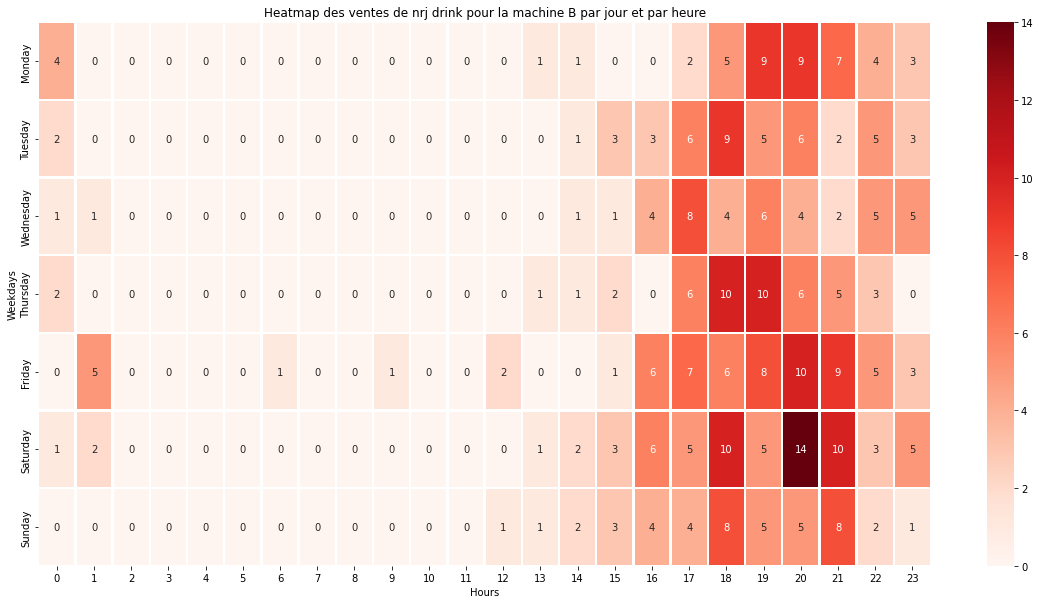

In [ ]:
plt.subplots(figsize = (20, 10))

hm7 = sns.heatmap(data=nrj_b, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm7 = plt.title("Heatmap des ventes de nrj drink pour la machine B par jour et par heure")
hm7 = plt.xlabel("Hours")
hm7 = plt.ylabel("Weekdays")

### Machine C

In [ ]:
refill_C.reset_index(drop=True, inplace=True)

refill_C['sales'] = refill_C.groupby('product').cumcount() + 1
refill_C['revenue'] = refill_C.apply(lambda x: x['sales'] * (coffee_price - coffee_cost) if x['product'] == 'coffee' else x['sales'] * (soda_price - soda_cost) if x['product'] == 'soda' else x['sales'] * (nrj_price - nrj_cost) if x['product'] == 'nrj' else np.NaN, axis=1)
refill_C['max_stock'] = refill_C['product'].apply(lambda x: coffee_cap if x == 'coffee' else soda_cap if x == 'soda' else nrj_cap if x == 'nrj' else np.NaN)

In [ ]:
refill_C

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,2019-12-13,Friday,13,12,2019,soda,C,00:52,0,0h-1h,Night,0,1,0,1,1,1.0,120
1,2019-12-01,Sunday,1,12,2019,coffee,C,00:38,0,0h-1h,Night,1,0,0,1,1,0.7,280
2,2019-12-13,Friday,13,12,2019,soda,C,00:26,0,0h-1h,Night,0,1,0,1,2,2.0,120
3,2019-12-13,Friday,13,12,2019,soda,C,00:20,0,0h-1h,Night,0,1,0,1,3,3.0,120
4,2019-12-13,Friday,13,12,2019,nrj,C,00:18,0,0h-1h,Night,0,0,1,1,1,1.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2019-11-28,Thursday,28,11,2019,soda,C,23:34,23,23h-24h,Night,0,1,0,1,718,718.0,120
2756,2019-11-28,Thursday,28,11,2019,soda,C,23:03,23,23h-24h,Night,0,1,0,1,719,719.0,120
2757,2019-12-14,Saturday,14,12,2019,nrj,C,23:25,23,23h-24h,Night,0,0,1,1,359,359.0,60
2758,2019-12-14,Saturday,14,12,2019,nrj,C,23:46,23,23h-24h,Night,0,0,1,1,360,360.0,60


In [ ]:
# Tableau des jours sur la machine C :

df_days_C = refill_C.groupby(['day', 'product']).count().reset_index()
df_days_C

,day,product,date,num_day,month,year,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,Friday,coffee,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580,580
1,Friday,nrj,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156,156
2,Friday,soda,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286,286
3,Monday,coffee,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529,529
4,Monday,soda,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43
5,Saturday,coffee,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
6,Saturday,nrj,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
7,Saturday,soda,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128,128
8,Sunday,coffee,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194,194
9,Sunday,nrj,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14


In [ ]:
fig = px.bar(df_days_C, x='day', y="count_any", template='plotly_dark', color="product", text="product", 
             category_orders={"product": ["coffee", "nrj", "soda"], "day": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}, 
             title = 'Total des ventes par jour sur le distributeur C',
             labels = {'day': ' ', "count_any":"Ventes"},
             )
fig.update_layout(showlegend=False, title_x=0.5)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
coffee_c = refill_C.pivot_table(index=['day'], columns='h', values='count_coffee', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
coffee_c.replace(np.NaN, 0, inplace=True)
coffee_c

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,3.0,9.0,0.0,0.0,0.0,26.0,49.0,44.0,53.0,53.0,...,30.0,17.0,24.0,11.0,7.0,6.0,2.0,3.0,2.0,3.0
Tuesday,0.0,1.0,0.0,0.0,0.0,10.0,5.0,11.0,16.0,11.0,...,3.0,7.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,34.0,20.0,11.0,5.0,4.0,4.0,3.0,2.0,0.0,3.0
Friday,6.0,7.0,0.0,0.0,0.0,34.0,45.0,46.0,55.0,66.0,...,35.0,34.0,18.0,8.0,6.0,2.0,3.0,2.0,3.0,4.0
Saturday,4.0,1.0,0.0,0.0,0.0,8.0,15.0,13.0,27.0,18.0,...,4.0,9.0,8.0,5.0,3.0,4.0,0.0,0.0,3.0,0.0
Sunday,4.0,0.0,0.0,0.0,0.0,15.0,23.0,23.0,15.0,16.0,...,9.0,7.0,5.0,5.0,1.0,2.0,1.0,1.0,0.0,1.0


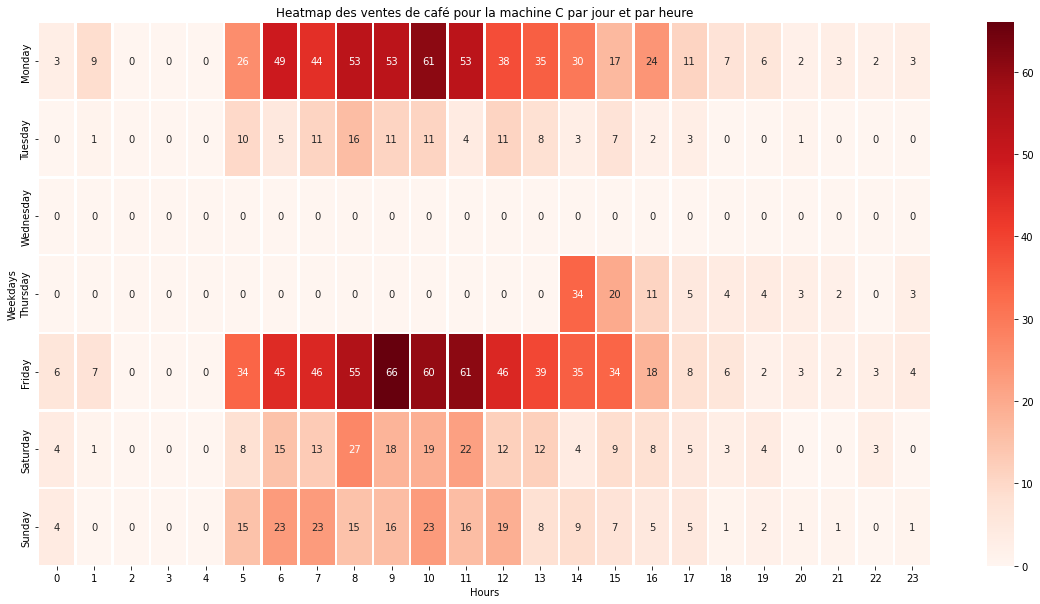

In [ ]:
plt.subplots(figsize = (20, 10))

hm8 = sns.heatmap(data=coffee_c, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm8 = plt.title("Heatmap des ventes de café pour la machine C par jour et par heure")
hm8 = plt.xlabel("Hours")
hm8 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
soda_c = refill_C.pivot_table(index=['day'], columns='h', values='count_soda', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
soda_c.replace(np.NaN, 0, inplace=True)
soda_c

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,...,2.0,3.0,2.0,3.0,3.0,3.0,0.0,1.0,1.0,2.0
Tuesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,14.0,11.0,15.0,11.0,18.0,20.0,7.0,9.0,5.0
Friday,11.0,8.0,0.0,0.0,0.0,10.0,11.0,11.0,17.0,16.0,...,16.0,14.0,20.0,16.0,14.0,13.0,9.0,14.0,10.0,13.0
Saturday,5.0,1.0,0.0,0.0,0.0,7.0,4.0,5.0,4.0,10.0,...,5.0,14.0,7.0,3.0,6.0,6.0,4.0,3.0,2.0,4.0
Sunday,6.0,2.0,0.0,0.0,0.0,4.0,8.0,11.0,7.0,8.0,...,5.0,8.0,3.0,12.0,6.0,2.0,3.0,3.0,5.0,7.0


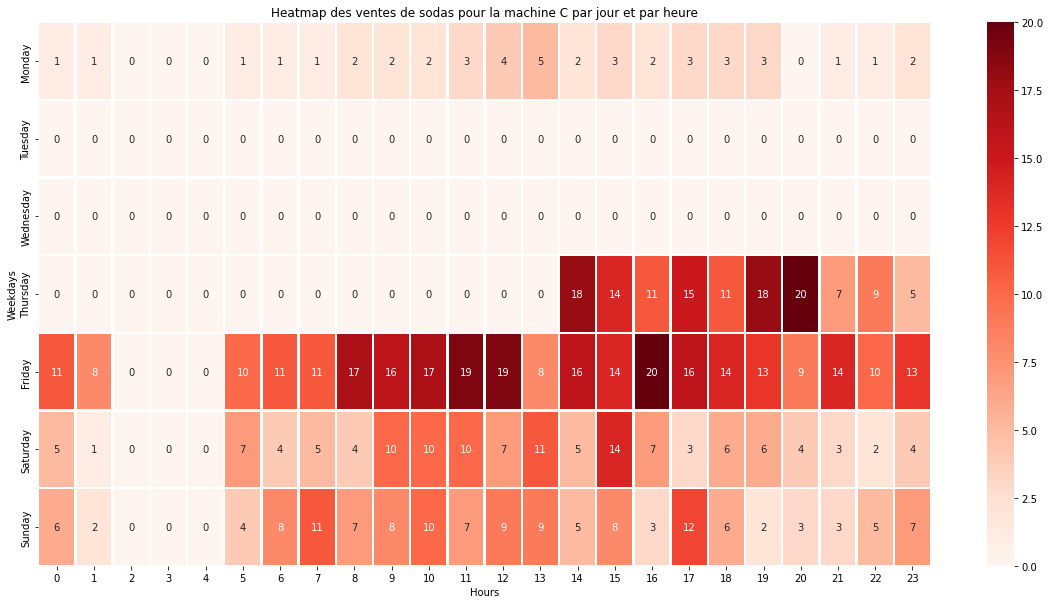

In [ ]:
plt.subplots(figsize = (20, 10))

hm9 = sns.heatmap(data=soda_c, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm9 = plt.title("Heatmap des ventes de sodas pour la machine C par jour et par heure")
hm9 = plt.xlabel("Hours")
hm9 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
nrj_c = refill_C.pivot_table(index=['day'], columns='h', values='count_nrj', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
nrj_c.replace(np.NaN, 0, inplace=True)
nrj_c

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Tuesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,7.0,7.0,8.0,3.0,9.0,6.0,4.0,2.0
Friday,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,3.0,12.0,14.0,25.0,19.0,23.0,29.0,7.0,4.0
Saturday,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,10.0,11.0,17.0,16.0,17.0,27.0,15.0,7.0
Sunday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,1.0,3.0,2.0,1.0,2.0,2.0


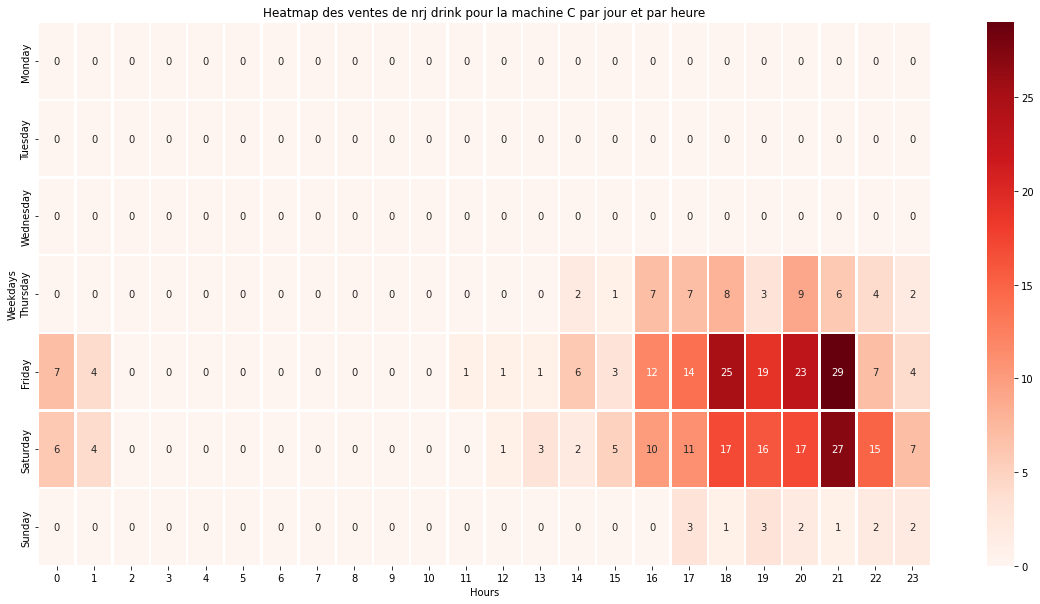

In [ ]:
plt.subplots(figsize = (20, 10))

hm10 = sns.heatmap(data=nrj_c, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm10 = plt.title("Heatmap des ventes de nrj drink pour la machine C par jour et par heure")
hm10 = plt.xlabel("Hours")
hm10 = plt.ylabel("Weekdays")

### Machine D

In [ ]:
refill_D.reset_index(drop=True, inplace=True)

refill_D['sales'] = refill_D.groupby('product').cumcount() + 1
refill_D['revenue'] = refill_D.apply(lambda x: x['sales'] * (coffee_price - coffee_cost) if x['product'] == 'coffee' else x['sales'] * (soda_price - soda_cost) if x['product'] == 'soda' else x['sales'] * (nrj_price - nrj_cost) if x['product'] == 'nrj' else np.NaN, axis=1)
refill_D['max_stock'] = refill_D['product'].apply(lambda x: coffee_cap if x == 'coffee' else soda_cap if x == 'soda' else nrj_cap if x == 'nrj' else np.NaN)

In [ ]:
refill_D

,date,day,num_day,month,year,product,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,2019-12-23,Monday,23,12,2019,soda,D,00:19,0,0h-1h,Night,0,1,0,1,1,1.0,120
1,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1,2,2.0,120
2,2019-12-13,Friday,13,12,2019,soda,D,00:48,0,0h-1h,Night,0,1,0,1,3,3.0,120
3,2019-11-16,Saturday,16,11,2019,nrj,D,00:11,0,0h-1h,Night,0,0,1,1,1,1.0,60
4,2019-12-13,Friday,13,12,2019,nrj,D,00:27,0,0h-1h,Night,0,0,1,1,2,2.0,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2754,2019-12-13,Friday,13,12,2019,soda,D,23:57,23,23h-24h,Night,0,1,0,1,718,718.0,120
2755,2019-11-28,Thursday,28,11,2019,nrj,D,23:28,23,23h-24h,Night,0,0,1,1,358,358.0,60
2756,2019-11-28,Thursday,28,11,2019,soda,D,23:24,23,23h-24h,Night,0,1,0,1,719,719.0,120
2757,2019-11-16,Saturday,16,11,2019,nrj,D,23:36,23,23h-24h,Night,0,0,1,1,359,359.0,60


In [ ]:
# Tableau des jours sur la machine D :

df_days_D = refill_D.groupby(['day', 'product']).count().reset_index()
df_days_D

,day,product,date,num_day,month,year,machine,hour,h,t_hours,period,count_coffee,count_soda,count_nrj,count_any,sales,revenue,max_stock
0,Friday,coffee,502,502,502,502,502,502,502,502,502,502,502,502,502,502,502,502
1,Friday,nrj,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124,124
2,Friday,soda,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263
3,Monday,coffee,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542,542
4,Monday,nrj,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
5,Monday,soda,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158,158
6,Saturday,coffee,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162,162
7,Saturday,nrj,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129,129
8,Saturday,soda,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104,104
9,Sunday,coffee,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163


In [ ]:
fig = px.bar(df_days_D, x='day', y="count_any", color="product", text="product", 
             category_orders={"product": ["coffee", "nrj", "soda"], "day": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]}, 
             title = 'Total des ventes par jour sur le distributeur D',
             labels = {'day': ' ', "count_any":"Ventes"},
             )
fig.update_layout(showlegend=False, title_x=0.5)
fig.update_xaxes(type='category')
fig.show()

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
coffee_d = refill_D.pivot_table(index=['day'], columns='h', values='count_coffee', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
coffee_d.replace(np.NaN, 0, inplace=True)
coffee_d

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,5.0,7.0,0.0,0.0,0.0,28.0,52.0,45.0,53.0,54.0,...,37.0,30.0,15.0,13.0,5.0,3.0,2.0,2.0,0.0,3.0
Tuesday,6.0,2.0,0.0,0.0,0.0,20.0,19.0,20.0,22.0,22.0,...,24.0,10.0,8.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,11.0,14.0,7.0,4.0,2.0,1.0,0.0,0.0
Friday,4.0,6.0,0.0,0.0,0.0,25.0,45.0,40.0,48.0,53.0,...,22.0,29.0,17.0,13.0,4.0,1.0,2.0,3.0,0.0,2.0
Saturday,2.0,1.0,0.0,0.0,0.0,12.0,11.0,22.0,10.0,16.0,...,13.0,11.0,4.0,2.0,1.0,0.0,2.0,1.0,0.0,0.0
Sunday,1.0,1.0,0.0,0.0,0.0,8.0,11.0,10.0,21.0,13.0,...,11.0,7.0,9.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0


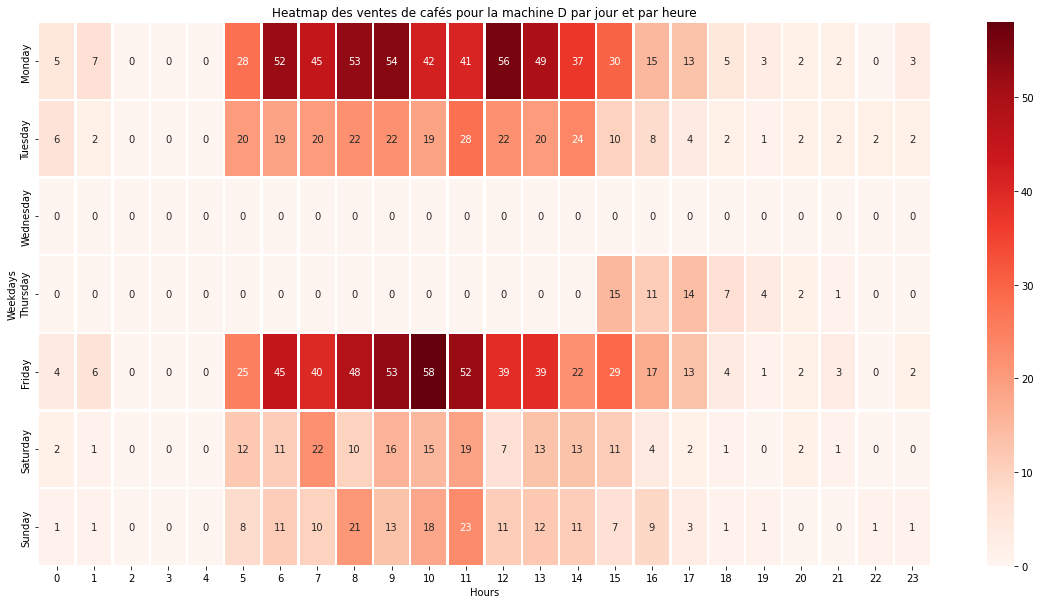

In [ ]:
plt.subplots(figsize = (20, 10))

hm11 = sns.heatmap(data=coffee_d, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm11 = plt.title("Heatmap des ventes de cafés pour la machine D par jour et par heure")
hm11 = plt.xlabel("Hours")
hm11 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
soda_d = refill_D.pivot_table(index=['day'], columns='h', values='count_soda', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
soda_d.replace(np.NaN, 0, inplace=True)
soda_d

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,7.0,7.0,0.0,0.0,0.0,3.0,8.0,8.0,10.0,4.0,...,10.0,10.0,8.0,8.0,3.0,6.0,8.0,11.0,4.0,5.0
Tuesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,10.0,11.0,19.0,8.0,5.0,12.0,3.0,11.0
Friday,8.0,11.0,0.0,0.0,0.0,15.0,10.0,14.0,13.0,17.0,...,13.0,17.0,13.0,10.0,11.0,14.0,7.0,10.0,7.0,11.0
Saturday,2.0,5.0,0.0,0.0,0.0,2.0,4.0,6.0,3.0,9.0,...,7.0,3.0,6.0,4.0,5.0,6.0,6.0,2.0,3.0,4.0
Sunday,3.0,6.0,0.0,0.0,0.0,7.0,5.0,5.0,4.0,7.0,...,3.0,4.0,2.0,4.0,4.0,2.0,5.0,5.0,4.0,6.0


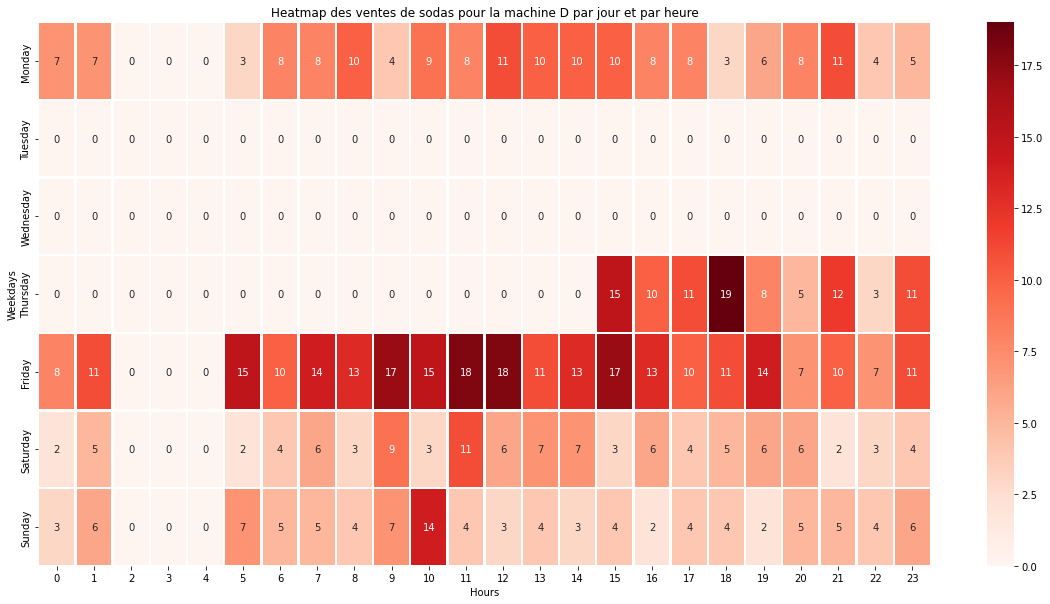

In [ ]:
plt.subplots(figsize = (20, 10))

hm12 = sns.heatmap(data=soda_d, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm12 = plt.title("Heatmap des ventes de sodas pour la machine D par jour et par heure")
hm12 = plt.xlabel("Hours")
hm12 = plt.ylabel("Weekdays")

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
nrj_d = refill_D.pivot_table(index=['day'], columns='h', values='count_nrj', aggfunc='sum').reindex(columns=np.arange(24), index=index, fill_value=0)
nrj_d.replace(np.NaN, 0, inplace=True)
nrj_d

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,3.0,3.0,3.0,3.0,2.0,5.0,1.0
Tuesday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,2.0,0.0,1.0,5.0,0.0,2.0,4.0
Wednesday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,3.0,2.0,3.0,1.0,1.0,0.0
Thursday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,2.0,4.0,4.0,7.0,2.0,1.0,1.0,2.0
Friday,8.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,5.0,9.0,8.0,9.0,15.0,17.0,13.0,9.0,10.0,13.0
Saturday,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,5.0,5.0,16.0,15.0,25.0,20.0,13.0,9.0,7.0
Sunday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,3.0,5.0,3.0,3.0,4.0,2.0,4.0,0.0


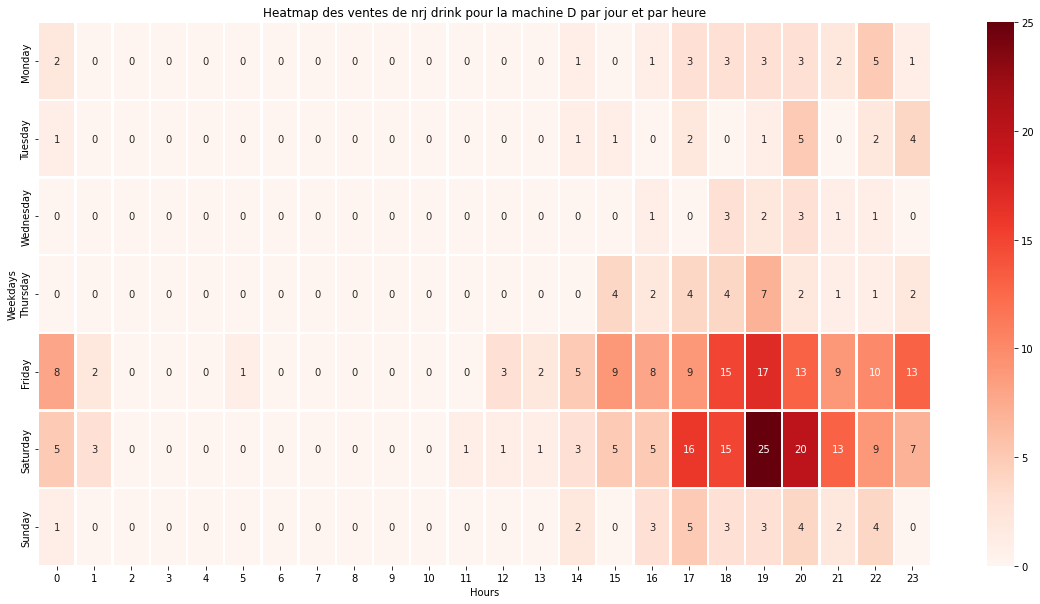

In [ ]:
plt.subplots(figsize = (20, 10))

hm13 = sns.heatmap(data=nrj_d, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True,
                   linewidths = 1.5)
hm13 = plt.title("Heatmap des ventes de nrj drink pour la machine D par jour et par heure")
hm13 = plt.xlabel("Hours")
hm13 = plt.ylabel("Weekdays")

## Jour des dernières boissons vendues (ne pas relancer systématiquement)

In [ ]:
df_last_coffee = pd.DataFrame(columns = ["date", "product", "machine", "h"])
df_last_soda = pd.DataFrame(columns = ["date", "product", "machine", "h"])
df_last_nrj = pd.DataFrame(columns = ["date", "product", "machine", "h"])

In [ ]:
# Rappel :

refill_A = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "A")]
refill_B = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "B")]
refill_C = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "C")]
refill_D = df_boisson.loc[(df_boisson['product'] == "refill") & (df_boisson['machine'] == "D")]

In [ ]:
for v in range (len(df_boisson["machine"].unique())):
  for i in range (len(refill_A)):
    if i+1 <= (len(refill_A)-1):
      new_row = df_boisson.loc[(df_boisson['product'] == "coffee") & (df_boisson['machine'] == df_boisson["machine"].unique()[v]) & (df_boisson.index >= refill_A.index[i]) & (df_boisson.index < refill_A.index[i+1])].tail(1)
      df_last_coffee = df_last_coffee.append(new_row, ignore_index=True)
      new_row = df_boisson.loc[(df_boisson['product'] == "soda") & (df_boisson['machine'] == df_boisson["machine"].unique()[v]) & (df_boisson.index >= refill_A.index[i]) & (df_boisson.index < refill_A.index[i+1])].tail(1)
      df_last_soda = df_last_soda.append(new_row, ignore_index=True)
      new_row = df_boisson.loc[(df_boisson['product'] == "nrj") & (df_boisson['machine'] == df_boisson["machine"].unique()[v]) & (df_boisson.index >= refill_A.index[i]) & (df_boisson.index < refill_A.index[i+1])].tail(1)
      df_last_nrj = df_last_nrj.append(new_row, ignore_index=True)

df_last_coffee

# Si chargement trop long, relancer le df jusqu'à "Création de nouvelles colonnes" inclus

,date,product,machine,h,hour,day,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-19,coffee,A,20,20:34,Tuesday,19.0,11.0,2019.0,Evening,1.0,0.0,0.0,1.0
1,2019-11-26,coffee,A,15,15:26,Tuesday,26.0,11.0,2019.0,Afternoon,1.0,0.0,0.0,1.0
2,2019-12-03,coffee,A,22,22:58,Tuesday,3.0,12.0,2019.0,Night,1.0,0.0,0.0,1.0
3,2019-12-10,coffee,A,22,22:09,Tuesday,10.0,12.0,2019.0,Night,1.0,0.0,0.0,1.0
4,2019-12-17,coffee,A,17,17:52,Tuesday,17.0,12.0,2019.0,Afternoon,1.0,0.0,0.0,1.0
5,2019-11-20,coffee,B,9,09:19,Wednesday,20.0,11.0,2019.0,Morning,1.0,0.0,0.0,1.0
6,2019-11-26,coffee,B,21,21:35,Tuesday,26.0,11.0,2019.0,Evening,1.0,0.0,0.0,1.0
7,2019-12-03,coffee,B,19,19:54,Tuesday,3.0,12.0,2019.0,Evening,1.0,0.0,0.0,1.0
8,2019-12-10,coffee,B,20,20:48,Tuesday,10.0,12.0,2019.0,Evening,1.0,0.0,0.0,1.0
9,2019-12-17,coffee,B,20,20:48,Tuesday,17.0,12.0,2019.0,Evening,1.0,0.0,0.0,1.0


In [ ]:
new_index = ['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday']

In [ ]:
df_last_coffee['day'] = pd.Categorical(df_last_coffee['day'], categories = new_index, ordered=True)
df_last_coffee = df_last_coffee.sort_values('day')

fig = px.bar(df_last_coffee, x='day', y="date", template = 'plotly_dark', text = "machine", title = 'Jour des derniers cafés vendus par machine', labels = {'day': ''}, width = 1200, height = 600)
fig.update_layout(showlegend=False, title_x = 0.5, yaxis = {'visible': False})
fig.show()

Epuisement des cafés le mardi midi.

In [ ]:
df_last_soda

,date,product,machine,h,hour,day,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-18,soda,A,23,23:23,Monday,18.0,11.0,2019.0,Night,0.0,1.0,0.0,1.0
1,2019-11-25,soda,A,19,19:42,Monday,25.0,11.0,2019.0,Evening,0.0,1.0,0.0,1.0
2,2019-12-05,soda,A,12,12:11,Thursday,5.0,12.0,2019.0,Morning,0.0,1.0,0.0,1.0
3,2019-12-12,soda,A,12,12:20,Thursday,12.0,12.0,2019.0,Morning,0.0,1.0,0.0,1.0
4,2019-12-16,soda,A,18,18:43,Monday,16.0,12.0,2019.0,Evening,0.0,1.0,0.0,1.0
5,2019-11-19,soda,B,19,19:56,Tuesday,19.0,11.0,2019.0,Evening,0.0,1.0,0.0,1.0
6,2019-11-26,soda,B,20,20:42,Tuesday,26.0,11.0,2019.0,Evening,0.0,1.0,0.0,1.0
7,2019-12-02,soda,B,23,23:36,Monday,2.0,12.0,2019.0,Night,0.0,1.0,0.0,1.0
8,2019-12-09,soda,B,21,21:19,Monday,9.0,12.0,2019.0,Evening,0.0,1.0,0.0,1.0
9,2019-12-16,soda,B,20,20:41,Monday,16.0,12.0,2019.0,Evening,0.0,1.0,0.0,1.0


In [ ]:
df_last_soda['day'] = pd.Categorical(df_last_soda['day'], categories = new_index, ordered=True)
df_last_soda = df_last_soda.sort_values('day')

fig = px.bar(df_last_soda, x='day', y="date", text = "machine", title = 'Jour des derniers sodas vendus par machine', labels = {'day': ''}, width = 1200, height = 600)
fig.update_layout(showlegend=False, title_x = 0.5, yaxis = {'visible': False})
fig.show()

Les sodas sont épuisés dès le lundi midi (voire le dimanche pour la machine C) ! Il faudrait les remplir une nouvelle fois le lundi matin.

In [ ]:
df_last_nrj

,date,product,machine,h,hour,day,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any
0,2019-11-20,nrj,A,20,20:17,Wednesday,20.0,11.0,2019.0,Evening,0.0,0.0,1.0,1.0
1,2019-11-28,nrj,A,0,00:01,Thursday,28.0,11.0,2019.0,Night,0.0,0.0,1.0,1.0
2,2019-12-04,nrj,A,22,22:21,Wednesday,4.0,12.0,2019.0,Night,0.0,0.0,1.0,1.0
3,2019-12-11,nrj,A,21,21:33,Wednesday,11.0,12.0,2019.0,Evening,0.0,0.0,1.0,1.0
4,2019-12-18,nrj,A,21,21:37,Wednesday,18.0,12.0,2019.0,Evening,0.0,0.0,1.0,1.0
5,2019-11-20,nrj,B,19,19:36,Wednesday,20.0,11.0,2019.0,Evening,0.0,0.0,1.0,1.0
6,2019-11-28,nrj,B,0,00:03,Thursday,28.0,11.0,2019.0,Night,0.0,0.0,1.0,1.0
7,2019-12-04,nrj,B,23,23:32,Wednesday,4.0,12.0,2019.0,Night,0.0,0.0,1.0,1.0
8,2019-12-12,nrj,B,0,00:08,Thursday,12.0,12.0,2019.0,Night,0.0,0.0,1.0,1.0
9,2019-12-18,nrj,B,23,23:58,Wednesday,18.0,12.0,2019.0,Night,0.0,0.0,1.0,1.0


In [ ]:
df_last_nrj['day'] = pd.Categorical(df_last_nrj['day'], categories = new_index, ordered=True)
df_last_nrj = df_last_nrj.sort_values('day')

fig = px.bar(df_last_nrj, x='day', y="date", template = 'plotly_dark', text = "machine", title = 'Jour des derniers nrj drink vendus par machine', labels = {'day': ''}, width = 1200, height = 600)
fig.update_layout(showlegend=False, title_x = 0.5, yaxis = {'visible': False})
fig.show()

Epuisement des nrj drink le mercredi généralement mais beaucoup d'épuisements dans la machine C le week-end, et même le jeudi sur les machines A et B !

On observe bien les problèmes de stocks les mardis, mercredis et jeudis matins (avant le passage de l'employé). 

Cela confirme que le technicien devrait faire un deuxième passage, dans l'idéal le lundi après-midi ou le mardi matin pour éviter d'éventuelles pertes.

## Ventes totales par boissons par jour et par heure (tous distributeurs)

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
tot = df_boisson.pivot_table(index=['day'], columns='h', values='product', aggfunc='count').reindex(columns=np.arange(24), index=index, fill_value=0)
tot.replace(np.NaN, 0, inplace=True)
tot

h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
Monday,37.0,44.0,0.0,0.0,0.0,128.0,198.0,194.0,229.0,222.0,...,158.0,123.0,100.0,75.0,52.0,54.0,45.0,40.0,30.0,37.0
Tuesday,15.0,10.0,0.0,0.0,0.0,66.0,63.0,84.0,109.0,96.0,...,56.0,46.0,29.0,28.0,24.0,11.0,22.0,8.0,16.0,13.0
Wednesday,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,4.0,6.0,10.0,10.0,13.0,11.0,8.0,8.0,5.0
Thursday,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,147.0,144.0,103.0,94.0,95.0,75.0,78.0,59.0,43.0,36.0
Friday,62.0,68.0,0.0,0.0,0.0,160.0,185.0,219.0,247.0,277.0,...,185.0,188.0,167.0,130.0,120.0,113.0,102.0,107.0,59.0,72.0
Saturday,35.0,29.0,0.0,0.0,0.0,62.0,71.0,94.0,87.0,105.0,...,69.0,81.0,79.0,73.0,82.0,86.0,80.0,76.0,53.0,48.0
Sunday,27.0,22.0,0.0,0.0,0.0,66.0,81.0,87.0,94.0,92.0,...,71.0,50.0,59.0,58.0,40.0,25.0,36.0,31.0,27.0,25.0


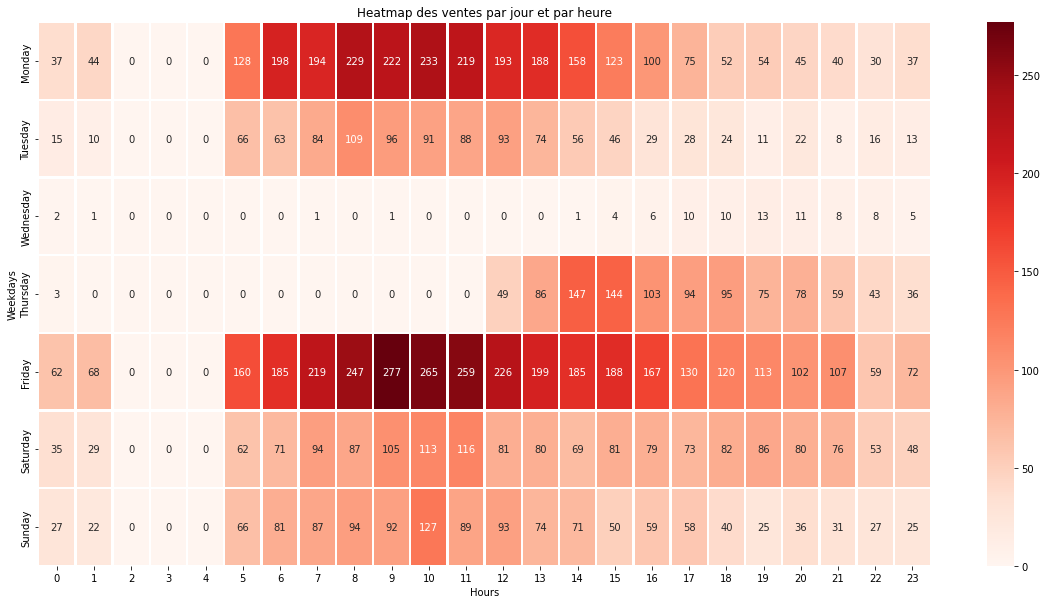

In [ ]:
plt.subplots(figsize = (20, 10))

hm14 = sns.heatmap(data=tot, 
                   xticklabels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], # 0 pour 2, 3, 4 car gare fermée
                   cmap = "Reds", 
                   annot = True, fmt='g', # Empêche d'avoir des nombres à puissances ;)
                   linewidths = 1.5)
hm14 = plt.title("Heatmap des ventes par jour et par heure")
hm14 = plt.xlabel("Hours")
hm14 = plt.ylabel("Weekdays")

In [ ]:
# Pour Machine A, B, C, D seulement (ne marche pas pour Stocks restants)

refill_A = df_boisson[df_boisson['machine'] == 'A'].copy(deep=True)
refill_B = df_boisson[df_boisson['machine'] == 'B'].copy(deep=True)
refill_C = df_boisson[df_boisson['machine'] == 'C'].copy(deep=True)
refill_D = df_boisson[df_boisson['machine'] == 'D'].copy(deep=True)

In [ ]:
# Alternative trouvée dans les corrections :

# Create a function to display the sales of the different products per day and hour as heatmaps :

def display_all(drink_type="any"):
    """Displays all the heatmaps for the different machines.

    Args:
        drink_type (str, optional): Selects the data to display.
        Select from "coffee", "soda", "nrj", "any". Any other string will display all 16 heatmaps.
        "any" will return the combined sales of the 3 drinks.
        Defaults to "any".
    """
    
    if drink_type == "count_any":
        counts = {'count_any': 'Combinés'}
    elif drink_type == "count_coffee":
        counts = {'count_coffee': 'Cafés'}
    elif drink_type == "count_soda":
        counts = {'count_soda': 'Sodas'}
    elif drink_type == "count_nrj":
        counts = {'count_nrj': 'Nrj'}
    else:
        counts = {'count_coffee': 'Cafés', 'count_soda': 'Sodas', 'count_nrj': 'Nrj', 'count_any': 'Total'}

    def display_heatmaps(df, letter):
        """Displays heamtmaps for all products, on a selected machine.

        Args:
            df (DataFrame): DataFrame containing the data to be displayed.
            letter (str): Machine letter.
        """
            
        for k, v in counts.items():
            pv = df_boisson.pivot_table(index=['day'], columns='h', values=k, aggfunc='sum').reindex(columns=np.arange(24), fill_value=0)
            pv.fillna(0, inplace=True)
            
            plt.figure(figsize=(20,10))
            sns.heatmap(pv, cmap='Reds', annot=True, fmt='g', linewidth=0.5, cbar=False, square=True)
            plt.title(f'{v} ventes par jour et par heure sur la machine {letter}')
            plt.xlabel('Hour')
            plt.ylabel('Day of the week')
            plt.show()
            
    dfs = [refill_A, refill_B, refill_C, refill_D]
    for i in dfs:
        display_heatmaps(i, i['machine'].iloc[0])   

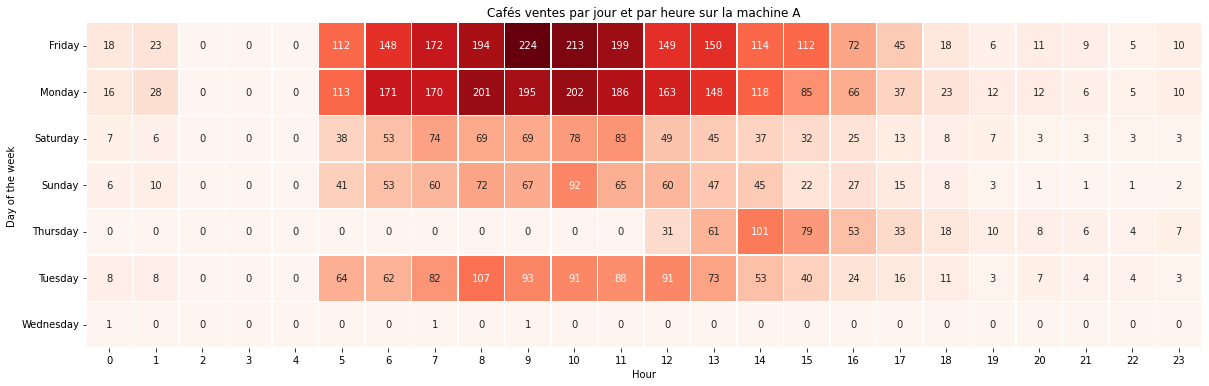

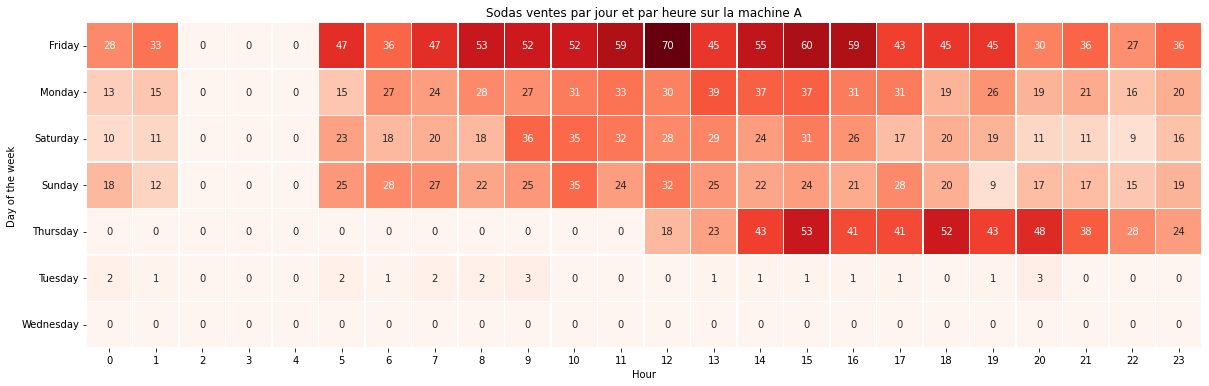

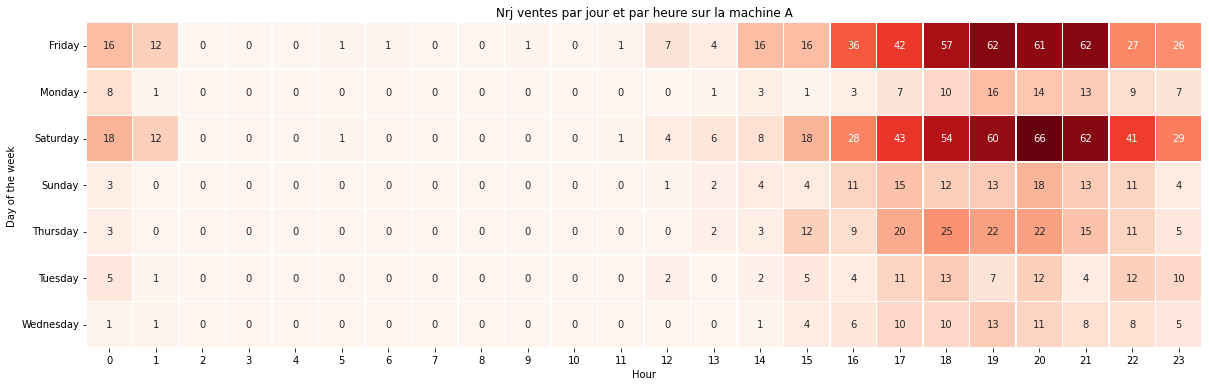

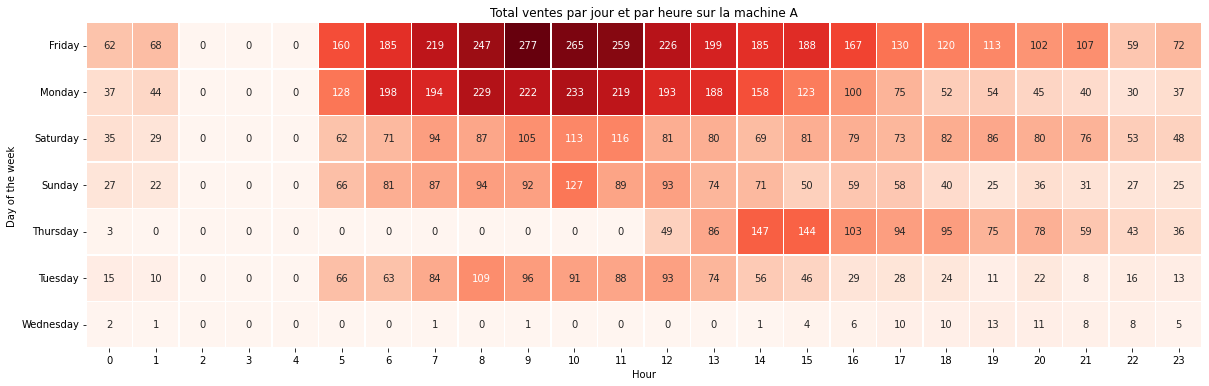

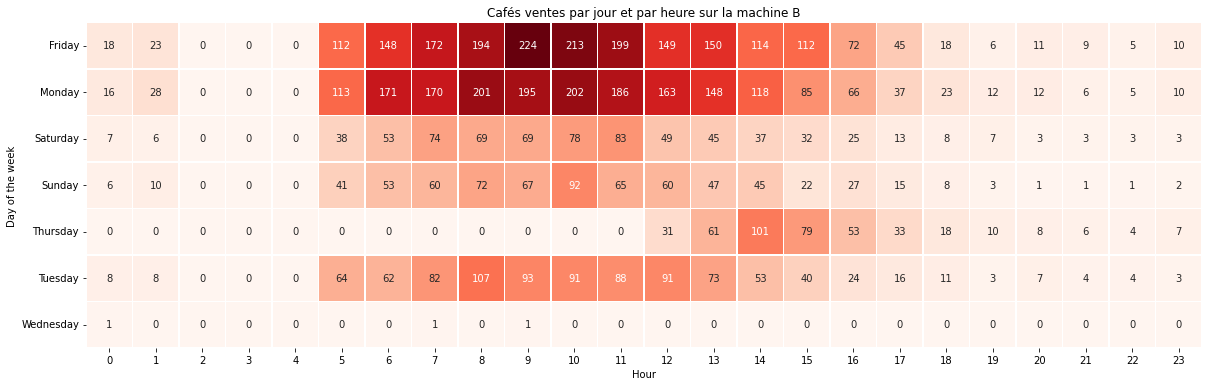

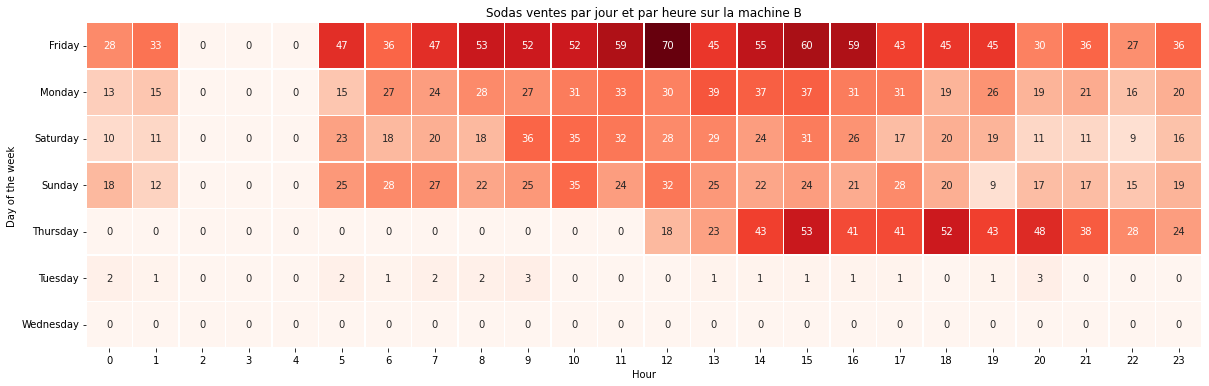

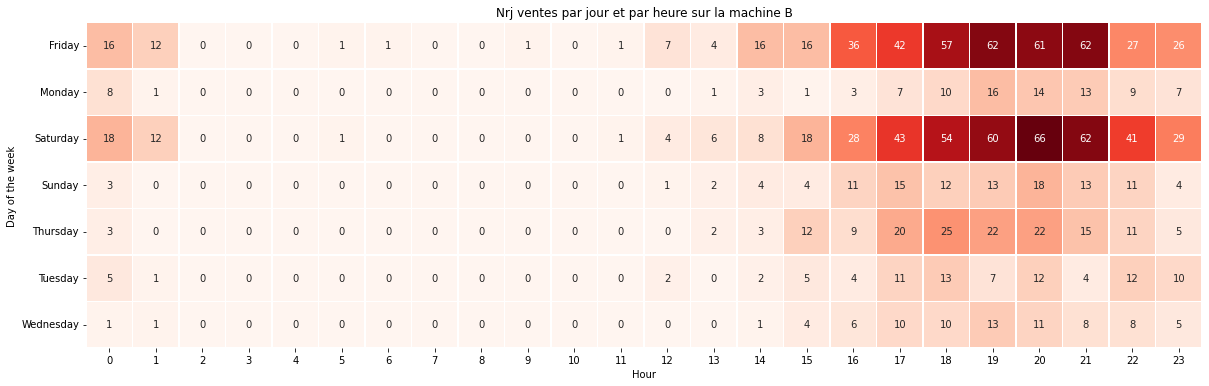

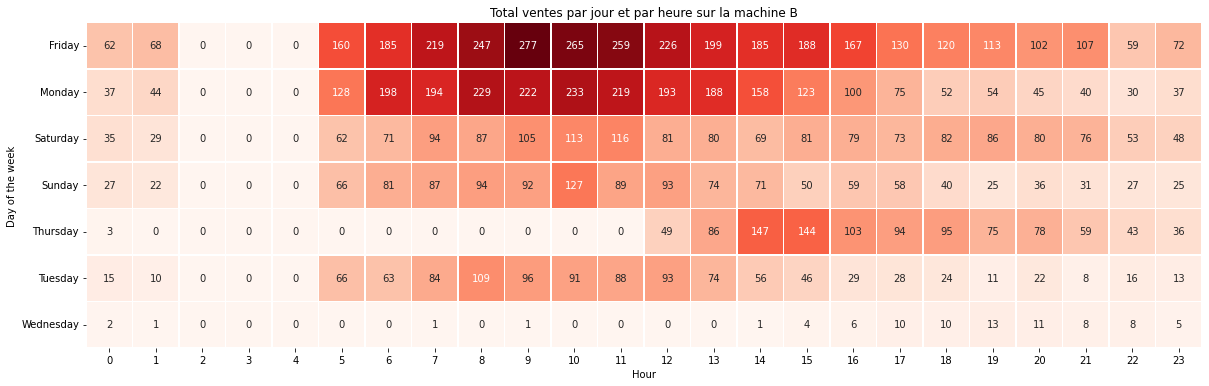

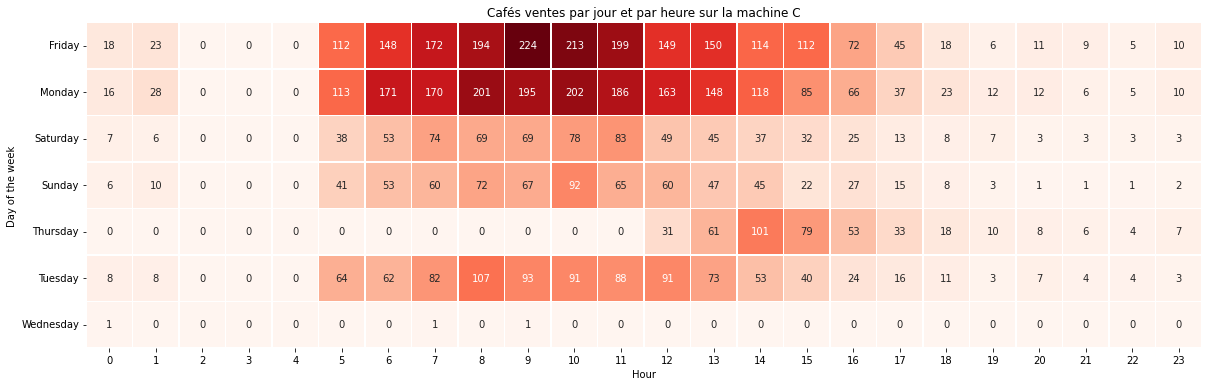

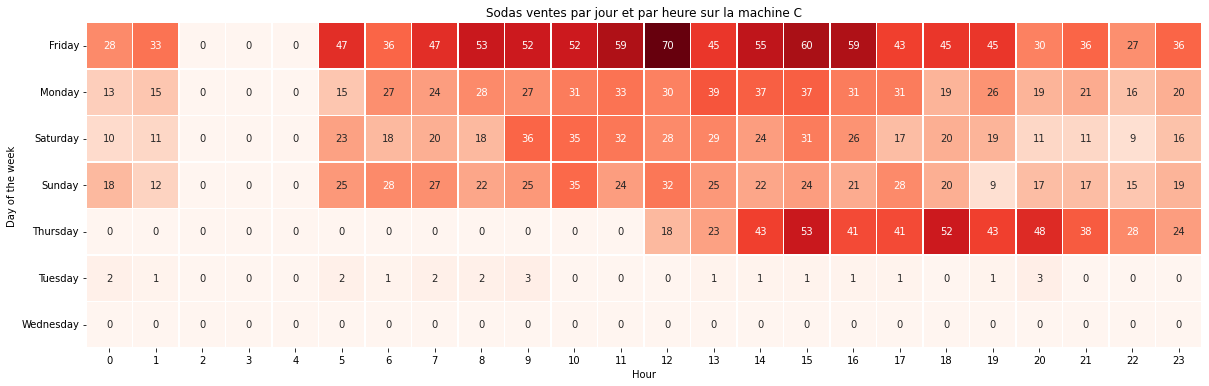

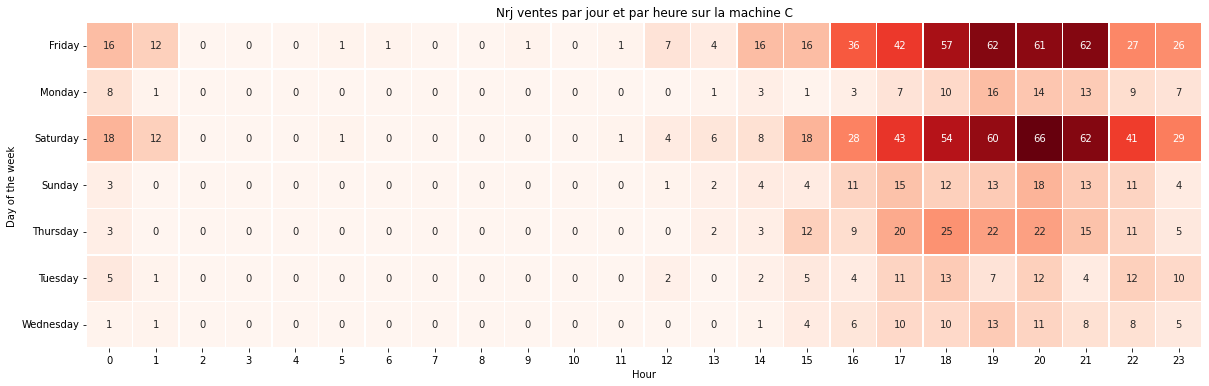

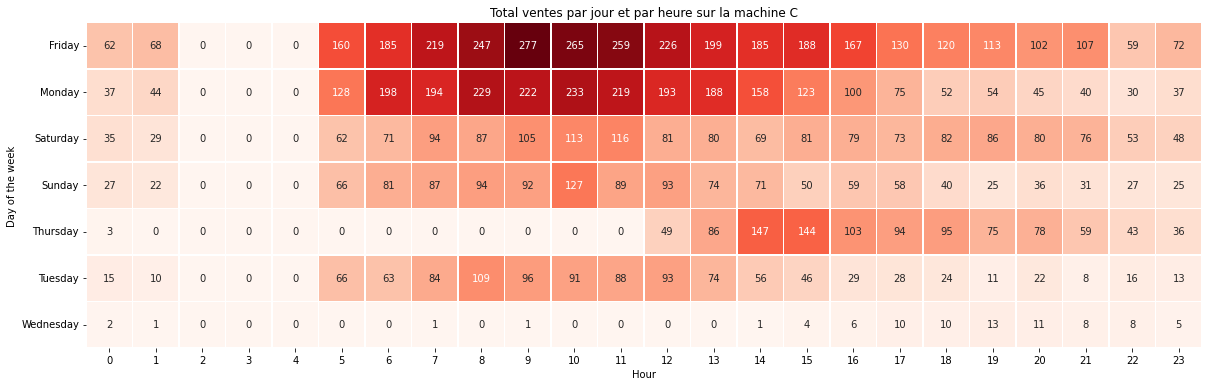

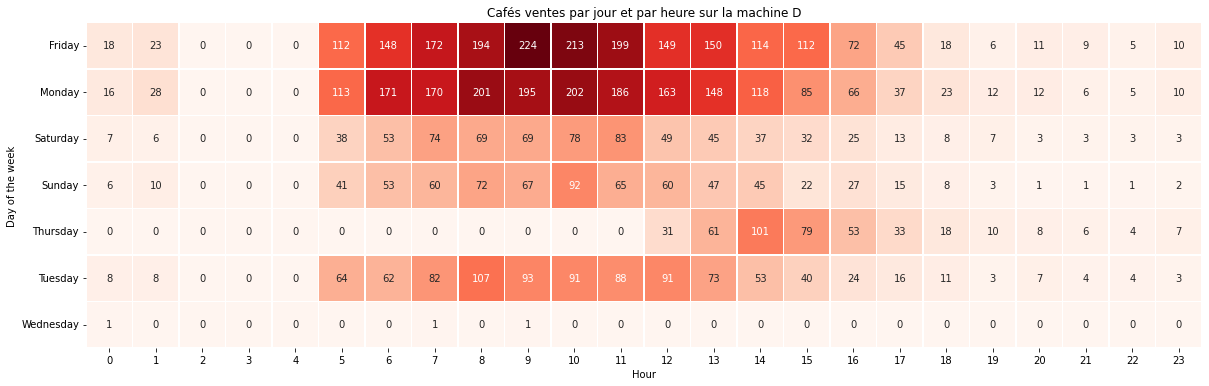

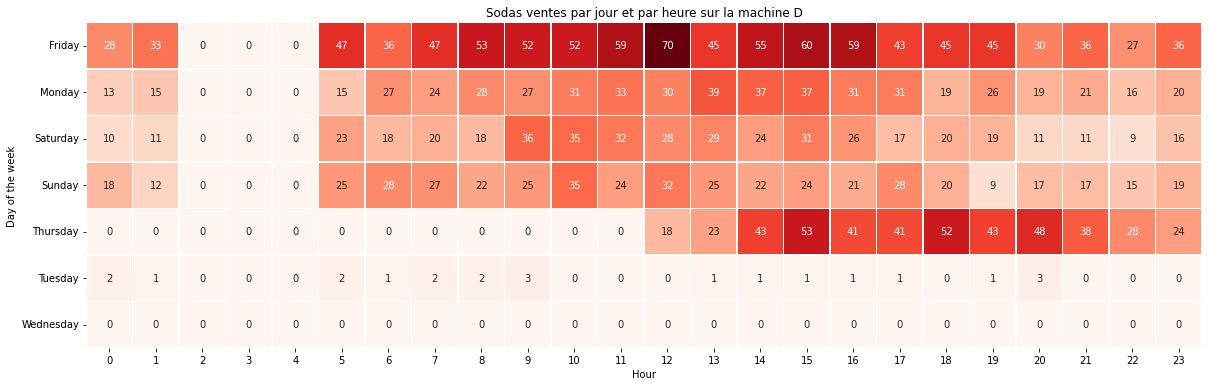

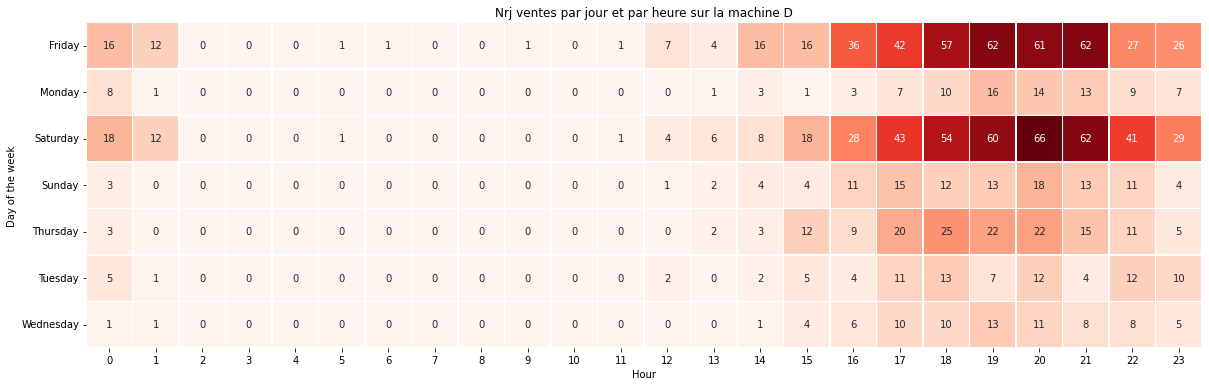

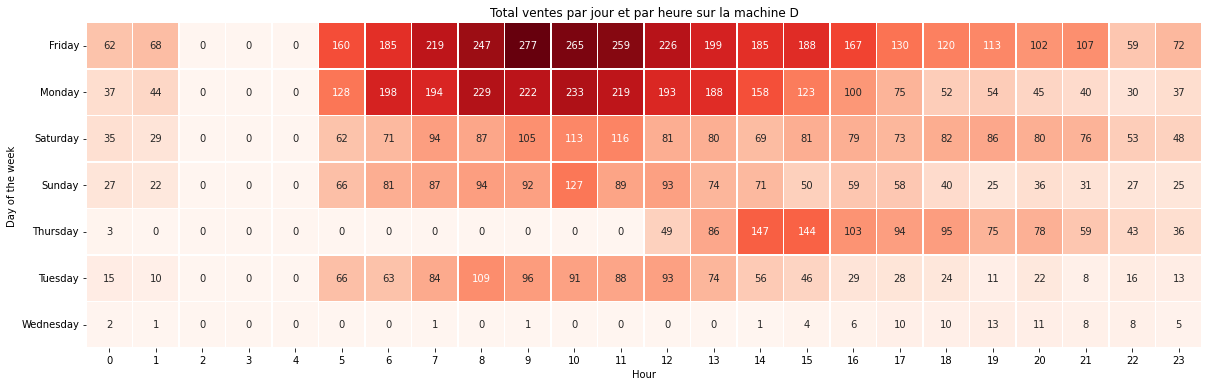

In [ ]:
display_all("any")

## Etude des stocks

In [ ]:
# Relancer car il ne faut pas la colonne t_hours sinon erreur :

refill_A = []

for drinks, machines in zip (df_boisson['product'], df_boisson['machine']):
    if drinks == 'refill' and machines == 'A':
        coffee = 280
        soda = 120
        nrj = 60
        refill_A.append(None)
    elif drinks == 'coffee' and machines == 'A':
        coffee -= 1
        refill_A.append(coffee)
    elif drinks == 'soda' and machines == 'A':
        soda -= 1
        refill_A.append(soda)
    elif drinks == 'nrj' and machines == 'A':
        nrj -= 1
        refill_A.append(nrj)
    else:
        refill_A.append(None)

In [ ]:
refill_B = []

for drinks, machines in zip (df_boisson['product'], df_boisson['machine']):
    if drinks == 'refill' and machines == 'B':
        coffee = 280
        soda = 120
        nrj = 60
        refill_B.append(None)
    elif drinks == 'coffee' and machines == 'B':
        coffee -= 1
        refill_B.append(coffee)
    elif drinks == 'soda' and machines == 'B':
        soda -= 1
        refill_B.append(soda)
    elif drinks == 'nrj' and machines == 'B':
        nrj -= 1
        refill_B.append(nrj)
    else:
        refill_B.append(None)

In [ ]:
refill_C = []

for drinks, machines in zip (df_boisson['product'], df_boisson['machine']):
    if drinks == 'refill' and machines == 'C':
        coffee = 280
        soda = 120
        nrj = 60
        refill_C.append(None)
    elif drinks == 'coffee' and machines == 'C':
        coffee -= 1
        refill_C.append(coffee)
    elif drinks == 'soda' and machines == 'C':
        soda -= 1
        refill_C.append(soda)
    elif drinks == 'nrj' and machines == 'C':
        nrj -= 1
        refill_C.append(nrj)
    else:
        refill_C.append(None)

In [ ]:
refill_D = []

for drinks, machines in zip (df_boisson['product'], df_boisson['machine']):
    if drinks == 'refill' and machines == 'D':
        coffee = 280
        soda = 120
        nrj = 60
        refill_D.append(None)
    elif drinks == 'coffee' and machines == 'D':
        coffee -= 1
        refill_D.append(coffee)
    elif drinks == 'soda' and machines == 'D':
        soda -= 1
        refill_D.append(soda)
    elif drinks == 'nrj' and machines == 'D':
        nrj -= 1
        refill_D.append(nrj)
    else:
        refill_D.append(None)

In [ ]:
df_boisson['machine_A'] = refill_A
df_boisson['machine_B'] = refill_B
df_boisson['machine_C'] = refill_C
df_boisson['machine_D'] = refill_D
df_boisson

,date,product,machine,hour,day,h,num_day,month,year,period,count_coffee,count_soda,count_nrj,count_any,machine_A,machine_B,machine_C,machine_D
0,2019-11-14,refill,A,11:53,Thursday,11,14,11,2019,Morning,0,0,0,0,NaN,NaN,NaN,NaN
1,2019-11-14,coffee,A,12:06,Thursday,12,14,11,2019,Morning,1,0,0,1,279.0,NaN,NaN,NaN
2,2019-11-14,soda,A,12:07,Thursday,12,14,11,2019,Morning,0,1,0,1,119.0,NaN,NaN,NaN
3,2019-11-14,soda,A,12:13,Thursday,12,14,11,2019,Morning,0,1,0,1,118.0,NaN,NaN,NaN
4,2019-11-14,coffee,A,12:22,Thursday,12,14,11,2019,Morning,1,0,0,1,278.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11037,2019-12-25,nrj,A,20:10,Wednesday,20,25,12,2019,Evening,0,0,1,1,3.0,NaN,NaN,NaN
11038,2019-12-25,nrj,B,20:16,Wednesday,20,25,12,2019,Evening,0,0,1,1,NaN,2.0,NaN,NaN
11039,2019-12-25,nrj,B,20:26,Wednesday,20,25,12,2019,Evening,0,0,1,1,NaN,1.0,NaN,NaN
11040,2019-12-25,nrj,B,21:11,Wednesday,21,25,12,2019,Evening,0,0,1,1,NaN,0.0,NaN,NaN


- Attention, certaines boissons dans certaines machines peuvent être épuisées dès le week-end (notamment les nrj drink de la machine C) !
- Il conviendrait de passer une deuxième fois dans la semaine, idéalement le lundi matin pour éviter l'épuisement du mardi tout en limitant les dégâts des machines vides le week-end.
- Le mercredi réalise de mauvaises ventes uniquement parce que les stocks sont vides !
- Tendances globales de ventes en fonction des périodes de la journée --> matin : cafés / soir : nrj drink